# Review-Based Defect Prediction & Product Quality Monitoring
\- Amisha Kelkar, Guyu Zhu, Pei-Chun Yang, Siddharth Kant, Shrinidhi Bhide

## Executive Summary

In this project, we analyzed Amazon verified reviews to develop a system for detecting potentially defective products. We focused on two product categories — Musical Instruments and Appliances — selected for their higher likelihood of quality issues. By processing a large volume of review text with PySpark, we aimed to build a scalable and efficient workflow that could identify defective products early, helping both consumers and vendors improve product satisfaction and quality control.

### Main Objectives
Our main objective was to create a scalable method to identify potentially defective products through textual review analysis. We focused on cleaning and preparing the data for analysis, developing a cosine similarity scoring approach to flag reviews indicating defects, and evaluating product-level patterns across two distinct product categories. Using Spark allowed us to efficiently manage large-scale processing and set a foundation for potential expansion to other categories.

### Key Findings
- Defect Centroid Creation:
We generated a defect centroid by embedding a manually selected list of defect-related keywords and calculated cosine similarity between each review and this centroid.
- Review Scoring and Labeling:
Reviews with a cosine similarity score greater than 0.75 were labeled as indicating potential defects. This threshold effectively separated negative reviews associated with product issues from neutral or positive feedback.
- Defect Rate Analysis by Product:
Products were evaluated based on the proportion of defect-flagged reviews. Several products in both categories exhibited defect rates exceeding 10%, indicating potential quality concerns.
- Category Differences:
On average, products in the Appliances category showed a slightly higher median defect rate compared to those in Musical Instruments, suggesting category-specific differences in product reliability.
- Model Performance:
A Logistic Regression model trained on the defect-labeled data achieved an AUC of 0.69, demonstrating reasonable predictive ability in distinguishing defective products from non-defective ones based on review features.
- Visualization Insights:
Visualizations revealed that while most products have low defect rates, there is a long tail of products with significantly higher defect rates, emphasizing the importance of early detection mechanisms.



## Introduction and Motivation
This project aims to analyze customer reviews and ratings across three major Amazon product categories: Electronics, Musical Instruments, and Appliances. By exploring large-scale review data, we seek to uncover patterns in customer satisfaction, identify which products receive the most feedback, and evaluate how rating distributions vary across different item types. Our goal is to gain insights into user experience and product performance at scale. The following focuses specifically on the Musical Instruments category and here is the url of the dataset: https://mcauleylab.ucsd.edu/public_datasets/data/amazon_2023/raw/meta_categories/meta_Appliances.jsonl.gz

For the purpose of this project, we chose 2 categories from the available ones to further analyze the reviews-
1. Musical Instruments
2. Appliances

For each of these categories, we have 2 tables i.e. the reviews table and the metadata table. After joining those tables, for relevancy we go on to filter the records for which the review is verified.

## Importing Necessary Libraries and Functions

In [ ]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, StringType, FloatType, ArrayType, IntegerType

from pyspark.ml.feature import (
    RegexTokenizer,
    StopWordsRemover,
    NGram,
    CountVectorizer,
    IDF,
    VectorAssembler
)
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors, DenseVector

from pyspark.sql.functions import (
    col,
    regexp_replace,
    lower,
    concat_ws,
    coalesce,
    lit,
    count,
    round,
    when,
    udf
)


In [ ]:
# Start Spark session
spark = SparkSession.builder.appName("Project_Big_Data").getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/01 15:31:39 INFO SparkEnv: Registering MapOutputTracker
25/04/01 15:31:39 INFO SparkEnv: Registering BlockManagerMaster
25/04/01 15:31:39 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
25/04/01 15:31:39 INFO SparkEnv: Registering OutputCommitCoordinator


## 1. Musical Instruments


### 1.1 Data Loading and Preprocessing


1. Meta Data<br>
The schema ensures proper data types for each column.

In [ ]:
#Defining the Schema
schema = StructType([
    StructField("main_category", StringType(), True),
    StructField("title", StringType(), True),
    StructField("average_rating", FloatType(), True),
    StructField("rating_number", IntegerType(), True),
    StructField("features", StringType(), True),
    StructField("description", StringType(), True),
    StructField("price", StringType(), True),
    StructField("images", StringType(), True),
    StructField("videos", StringType(), True),
    StructField("store", StringType(), True),
    StructField("categories", StringType(), True),
    StructField("details", StringType(), True),
    StructField("parent_asin", StringType(), True),
    StructField("bought_together", StringType(), True),
    StructField("subtitle", StringType(), True),
    StructField("author", StringType(), True)
])
gcs_path = "gs://amazon-review-project/project/musical_instruments_meta.csv"

df_musical_meta = spark.read.csv(
    gcs_path,
    header=True,
    schema=schema,
    multiLine=True,
    escape='"'
)

df_musical_meta.show(5)


+-------------------+--------------------+--------------+-------------+--------------------+--------------------+-----+--------------------+--------------------+---------+--------------------+--------------------+-----------+---------------+--------+------+
|      main_category|               title|average_rating|rating_number|            features|         description|price|              images|              videos|    store|          categories|             details|parent_asin|bought_together|subtitle|author|
+-------------------+--------------------+--------------+-------------+--------------------+--------------------+-----+--------------------+--------------------+---------+--------------------+--------------------+-----------+---------------+--------+------+
|Musical Instruments|Pearl Export Lacq...|           4.2|           22|['Item may ship i...|["Introducing the...| NULL|[{'thumb': 'https...|[{'title': 'Best ...|    Pearl|['Musical Instrum...|{'Item Weight': '...| B01M4HO6RK| 

Then convert the first 5 rows of the Spark DataFrame to a Pandas DataFrame for easier preview and interaction.

In [ ]:
df_musical_meta.limit(5).toPandas()

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author
0,Musical Instruments,Pearl Export Lacquer EXL725S/C249 5-Piece New ...,4.2,22,['Item may ship in more than one box and may a...,"[""Introducing the best selling drum set of all...",None,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Best Selling Drum Set of All Time'...,Pearl,"['Musical Instruments', 'Drums & Percussion', ...","{'Item Weight': '33 pounds', 'Product Dimensio...",B01M4HO6RK,None,None,None
1,Musical Instruments,Behringer EUROPOWER EPQ900 Professional 900 Wa...,4.0,13,['2 x 390 Watts into 4 Ohms; 2 x 245 Watts int...,"['BEHRINGER EUROPOWER EPQ900', 'Professional 9...",None,[{'thumb': 'https://m.media-amazon.com/images/...,[],Behringer,"['Musical Instruments', 'Live Sound & Stage', ...","{'Item Weight': '10.8 pounds', 'Product Dimens...",B00508JFE4,None,None,None
2,Musical Instruments,Washburn Classical Series Acoustic Electric Cu...,3.6,15,['The Washburn is truly a professional instrum...,['C64SCE CLASSICAL GUITAR The cutaway allows a...,399.0,[{'thumb': 'https://m.media-amazon.com/images/...,[],Washburn,"['Musical Instruments', 'Guitars']","{'Item Weight': '5.98 pounds', 'Product Dimens...",B000S5JGMU,None,None,None
3,Musical Instruments,"VocoPro, plug in, Black, 21.00 x 21.00 x 23.00...",3.5,7,"['Includes one microphone and one receiver', '...",['VocoPro UHF-18 DIAMOND - N Wireless Micropho...,112.0,[{'thumb': 'https://m.media-amazon.com/images/...,[],VocoPro,"['Musical Instruments', 'Live Sound & Stage', ...","{'Item Weight': '2.29 pounds', 'Product Dimens...",B00B2HLWZW,None,None,None
4,Musical Instruments,Shure SM7B Vocal Dynamic Microphone for Broadc...,4.9,9512,['ONE MICROPHONE FOR EVERYTHING - Studio Recor...,"['The SM7B dynamic microphone has a smooth, fl...",399.0,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'Shure SM7B Mic Demonstration', 'ur...",Shure,"['Musical Instruments', 'Microphones & Accesso...","{'Item Weight': '2.7 pounds', 'Product Dimensi...",B0B89ZSYS7,None,None,None


Display all available columns in the dataset, then select only the relevant fields for analysis, including category, ratings, and product details.

In [ ]:
df_musical_meta.columns

['main_category',
 'title',
 'average_rating',
 'rating_number',
 'features',
 'description',
 'price',
 'images',
 'videos',
 'store',
 'categories',
 'details',
 'parent_asin',
 'bought_together',
 'subtitle',
 'author']

In [ ]:
df_musical_meta= df_musical_meta.select('main_category',
 'title',
 'average_rating',
 'rating_number',
 'features',
 'description',
 'store',
 'categories',
 'details',
 'parent_asin')
df_musical_meta.limit(5).toPandas()

,main_category,title,average_rating,rating_number,features,description,store,categories,details,parent_asin
0,Musical Instruments,Pearl Export Lacquer EXL725S/C249 5-Piece New ...,4.2,22,['Item may ship in more than one box and may a...,"[""Introducing the best selling drum set of all...",Pearl,"['Musical Instruments', 'Drums & Percussion', ...","{'Item Weight': '33 pounds', 'Product Dimensio...",B01M4HO6RK
1,Musical Instruments,Behringer EUROPOWER EPQ900 Professional 900 Wa...,4.0,13,['2 x 390 Watts into 4 Ohms; 2 x 245 Watts int...,"['BEHRINGER EUROPOWER EPQ900', 'Professional 9...",Behringer,"['Musical Instruments', 'Live Sound & Stage', ...","{'Item Weight': '10.8 pounds', 'Product Dimens...",B00508JFE4
2,Musical Instruments,Washburn Classical Series Acoustic Electric Cu...,3.6,15,['The Washburn is truly a professional instrum...,['C64SCE CLASSICAL GUITAR The cutaway allows a...,Washburn,"['Musical Instruments', 'Guitars']","{'Item Weight': '5.98 pounds', 'Product Dimens...",B000S5JGMU
3,Musical Instruments,"VocoPro, plug in, Black, 21.00 x 21.00 x 23.00...",3.5,7,"['Includes one microphone and one receiver', '...",['VocoPro UHF-18 DIAMOND - N Wireless Micropho...,VocoPro,"['Musical Instruments', 'Live Sound & Stage', ...","{'Item Weight': '2.29 pounds', 'Product Dimens...",B00B2HLWZW
4,Musical Instruments,Shure SM7B Vocal Dynamic Microphone for Broadc...,4.9,9512,['ONE MICROPHONE FOR EVERYTHING - Studio Recor...,"['The SM7B dynamic microphone has a smooth, fl...",Shure,"['Musical Instruments', 'Microphones & Accesso...","{'Item Weight': '2.7 pounds', 'Product Dimensi...",B0B89ZSYS7


2. Reviews<br>
Define a schema and load the CSV file containing user reviews for musical instruments from Google Cloud Storage. The schema includes fields such as rating, review text, product ID, and user info.

In [ ]:
schema_reviews = StructType([
    StructField("rating", FloatType(), True),
    StructField("title", StringType(), True),
    StructField("text", StringType(), True),
    StructField("images", StringType(), True),
    StructField("asin", StringType(), True),
    StructField("parent_asin", StringType(), True),
    StructField("user_id", StringType(), True),
    StructField("timestamp", StringType(), True),
    StructField("helpful_vote", IntegerType(), True),
    StructField("verified_purchase", StringType(), True)
])
gcs_path = "gs://amazon-review-project/project/musical_instruments_reviews.csv"

df_musical_reviews = spark.read.csv(
    gcs_path,
    header=True,
    schema=schema_reviews,
    multiLine=True,
    escape='"'
)

df_musical_reviews.show(5)


+------+--------------------+--------------------+------+----------+-----------+--------------------+-------------+------------+-----------------+
|rating|               title|                text|images|      asin|parent_asin|             user_id|    timestamp|helpful_vote|verified_purchase|
+------+--------------------+--------------------+------+----------+-----------+--------------------+-------------+------------+-----------------+
|   5.0|          Five Stars|Great headphones,...|    []|B003LPTAYI| B003LPTAYI|AGKASBHYZPGTEPO6L...|1452650586000|           0|             True|
|   3.0|nice sound.  peda...|I like the piano....|    []|B00723436A| B06XP6TDVY|AGCI7FAH4GL5FI65H...|1558567365290|           2|             True|
|   4.0|                okay|pretty good overa...|    []|B0040FJ27S| B0040FJ27S|AGCI7FAH4GL5FI65H...|1384912482000|           0|             True|
|   3.0|     Easy to return.|Too bad it didn't...|    []|B00191WVF6| B00WJ3HL5I|AEM663T6XHZFWLODF...|1607055693671|   

List all columns in the review dataset, then retain only selected fields related to review content, product ID, user info, and review for further analysis.

In [ ]:
df_musical_reviews.columns

['rating',
 'title',
 'text',
 'images',
 'asin',
 'parent_asin',
 'user_id',
 'timestamp',
 'helpful_vote',
 'verified_purchase']

In [ ]:
df_musical_reviews=df_musical_reviews.select('rating',
 'title',
 'text',
 'asin',
 'parent_asin',
 'timestamp',
 'helpful_vote',
 'verified_purchase')

In [ ]:
df_musical_reviews.limit(5).toPandas()

,rating,title,text,asin,parent_asin,timestamp,helpful_vote,verified_purchase
0,5.0,Five Stars,"Great headphones, comfortable and sound is goo...",B003LPTAYI,B003LPTAYI,1452650586000,0,True
1,3.0,nice sound. pedal failed after less than 1 year,I like the piano.. but the sustain pedal faile...,B00723436A,B06XP6TDVY,1558567365290,2,True
2,4.0,okay,pretty good overall. I like it. the controll...,B0040FJ27S,B0040FJ27S,1384912482000,0,True
3,3.0,Easy to return.,Too bad it didn't work. At least the return pr...,B00191WVF6,B00WJ3HL5I,1607055693671,0,True
4,5.0,Good product despite tight bolt.,Good and sturdy but the bolt was hell to get o...,B07T9NM5QR,B07T9NM5QR,1622595785255,0,False


In [ ]:
df_musical_reviews = df_musical_reviews.withColumnRenamed("title", "review_title")


Join the metadata and review datasets using the shared parent_asin key. Then filter and clean the columns.

In [ ]:
df_musical_joined = df_musical_meta.join(df_musical_reviews, on = 'parent_asin', how= 'right')


In [ ]:
df_musical_verified  = df_musical_joined.filter(F.col("verified_purchase") == True)

In [ ]:
from pyspark.sql.functions import when, col

# Replace '[]' with NULL in the 'description' column
df_musical_verified = df_musical_verified.withColumn("description", when(col("description") == "[]", None).otherwise(col("description")))
df_musical_verified = df_musical_verified.withColumn("features", when(col("features") == "[]", None).otherwise(col("features")))
df_musical_verified = df_musical_verified.withColumn("categories", when(col("categories") == "[]", None).otherwise(col("categories")))


In [ ]:
df_musical_verified.limit(5).toPandas().head()

,parent_asin,main_category,title,average_rating,rating_number,features,description,store,categories,details,rating,review_title,text,asin,timestamp,helpful_vote,verified_purchase
0,B003LPTAYI,Home Audio & Theater,Sennheiser HD 202 II Professional Headphones (...,4.2,11767,"[""Ideal for DJ's and audio pros,Total harmonic...","['Product Description', 'The Sennheiser HD202I...",Sennheiser Consumer Audio,"['Musical Instruments', 'Pro & DJ Headphones']","{'Product Dimensions': '8 x 3 x 9.4 inches', '...",5.0,Five Stars,"Great headphones, comfortable and sound is goo...",B003LPTAYI,1452650586000,0,True
1,B0040FJ27S,Musical Instruments,LEDwholesalers 12-Volt 16.4-ft RGB Color-Chang...,4.5,1763,"['Complete kit includes: flexible LED strip, c...",['These LED color-changing flexible strips are...,LEDwholesalers,"['Musical Instruments', 'Live Sound & Stage', ...","{'Item Weight': '11.2 ounces', 'Product Dimens...",4.0,okay,pretty good overall. I like it. the controll...,B0040FJ27S,1384912482000,0,True
2,B00A2DBHMA,Computers,Microsoft Surface Touch Cover Keyboard | Black,4.3,829,"['Lightweight, 3mm thin pressure-sensitive key...",['3.25mm thin Weighs less than 0.46 lbs Pressu...,Microsoft,"['Musical Instruments', 'Instrument Accessorie...","{'Brand': 'Microsoft', 'Series': 'surface', 'I...",5.0,bluetooth key board,works great with my tablet,B00A2DBHMA,1546556517459,0,True
3,B00WJ3HL5I,Musical Instruments,DADDARIO 9-Volt Power Adaptor (PW-CT-9V),4.6,15012,['BATTERY FREE PERFORMANCE – You won’t need to...,None,D'Addario Accessories,"['Musical Instruments', 'Instrument Accessorie...","{'Brand': ""D'Addario Accessories"", 'Connector ...",3.0,Easy to return.,Too bad it didn't work. At least the return pr...,B00191WVF6,1607055693671,0,True
4,B06XP6TDVY,Musical Instruments,Korg SV-1BK 73-Key Stage Vintage Piano - Black,3.4,15,"[""73 keys; Korg's best RH3 Graded Hammer Actio...",['The SV-1 has been captivating audiences sinc...,Korg,"['Musical Instruments', 'Keyboards & MIDI', 'E...","{'Item Weight': '38.5 pounds', 'Product Dimens...",3.0,nice sound. pedal failed after less than 1 year,I like the piano.. but the sustain pedal faile...,B00723436A,1558567365290,2,True


### 1.2 Exploratory Data Analysis(EDA) and Data Visualization
1.Basic information

Check the schema of the cleaned DataFrame to confirm column names and data types.

In [ ]:
df_musical_verified.printSchema()

root
 |-- parent_asin: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- title: string (nullable = true)
 |-- average_rating: float (nullable = true)
 |-- rating_number: integer (nullable = true)
 |-- features: string (nullable = true)
 |-- description: string (nullable = true)
 |-- store: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- details: string (nullable = true)
 |-- rating: float (nullable = true)
 |-- review_title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- helpful_vote: integer (nullable = true)
 |-- verified_purchase: string (nullable = true)



Count the total number of rows(the number is so large so we use "limit"in the following steps to avoid system breakdown).

In [ ]:
df_musical_verified.count()

2780515

In [ ]:
df_musical_verified.groupBy('rating').count().show()

+------+-------+
|rating|  count|
+------+-------+
|   1.0| 238742|
|   5.0|1881880|
|   2.0| 118530|
|   4.0| 361978|
|   3.0| 179385|
+------+-------+




#### 1.2.1 Main categories and distribution

Group the data by main_category and count the number of reviews in each. Sort the result in descending order to identify the most reviewed product categories.


In [ ]:
df_musical_verified.groupBy("main_category").count().orderBy("count", ascending=False).show()

+--------------------+-------+
|       main_category|  count|
+--------------------+-------+
| Musical Instruments|2403057|
|     All Electronics| 109024|
|Home Audio & Theater|  38549|
|Industrial & Scie...|  37559|
|         Amazon Home|  36401|
|Tools & Home Impr...|  33833|
|                NULL|  17705|
|        Toys & Games|  17657|
|      AMAZON FASHION|  16792|
|           Computers|  16387|
|Cell Phones & Acc...|  12528|
|   Sports & Outdoors|   6969|
|     Office Products|   5952|
|      Camera & Photo|   5666|
|          Automotive|   4552|
|               Books|   4225|
|Health & Personal...|   3377|
|            Software|   3183|
|Arts, Crafts & Se...|   1898|
|          All Beauty|   1388|
+--------------------+-------+
only showing top 20 rows



Then we use visualization to make the result more easy to understand. Create a bar plot of the top 10 most reviewed categories using Seaborn. A log scale is also applied to the y-axis to handle large differences in review counts.

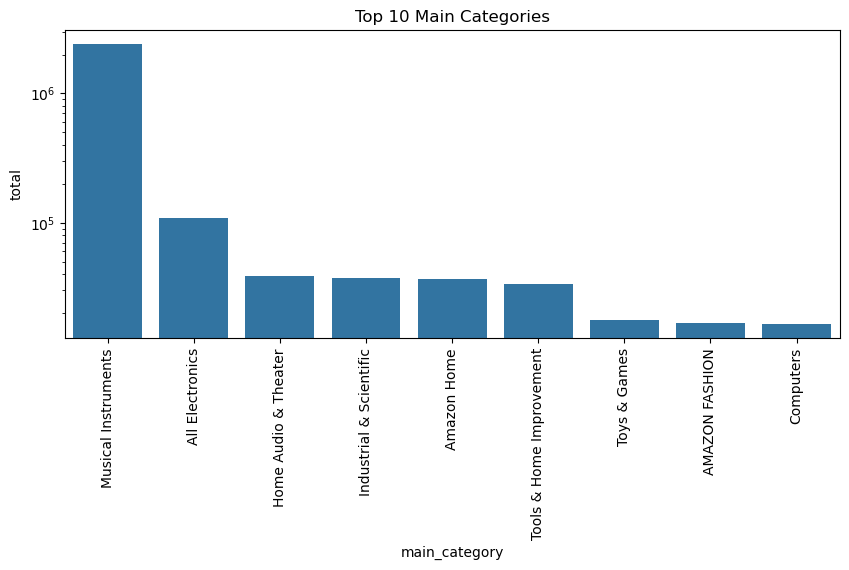

In [ ]:
viz1 = (
    df_musical_verified
    .groupBy("main_category")
    .agg(F.count("*").alias("total"))
    .orderBy(F.desc("total"))
    .limit(10)
    .cache()
    .toPandas()
)

plt.figure(figsize=(10, 4))
sns.barplot(data=viz1, x="main_category", y="total")
plt.yscale("log")
plt.xticks(rotation=90)
plt.title("Top 10 Main Categories")
plt.show()

This bar chart shows the top 10 product categories by number of verified reviews, highlighting the heavy concentration of data in a single category.
1. Musical Instruments overwhelmingly dominates with millions of reviews.
2. Other categories like All Electronics and Home Audio & Theater have significantly fewer reviews.
3. A logarithmic scale is used on the y-axis to better visualize the large differences in counts.

#### 1.2.2 Average rating distribution

This histogram displays the distribution of average product ratings from a sample of 100,000 verified reviews. Visualizing this distribution helps assess overall customer satisfaction and detect potential rating bias.

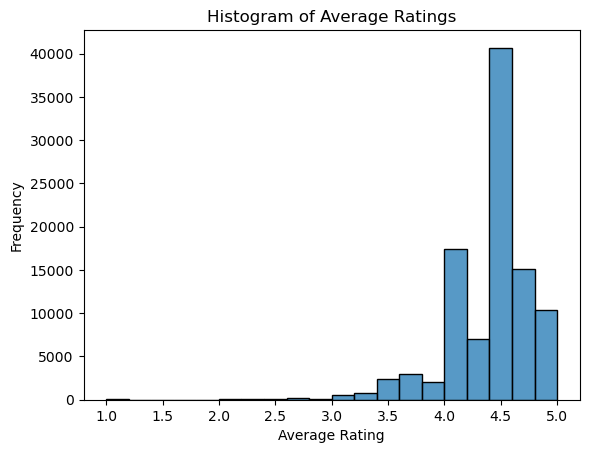

In [ ]:
sns.histplot(data=df_musical_verified.limit(100000).toPandas(), x="average_rating", bins=20)
plt.title("Histogram of Average Ratings")
plt.xlabel("Average Rating")
plt.ylabel("Frequency")
plt.show()


This histogram shows the distribution of average product ratings from a sample of verified reviews.
Most ratings are concentrated between 4.0 and 5.0, with a clear peak around 4.5, indicating a strong tendency for positive reviews.Ratings below 3.0 are extremely rare, highlighting a right-skewed pattern typical of user-generated product feedback.
This indicates that users tend to give high ratings, which may limit the usefulness of rating scores in distinguishing product quality.

#### 1.2.3 Comment data exploration
Next, the comment data is explored through basic statistics and visualizations.  This help us understand how users rate products and how many reviews different items receive. Such exploration helps identify possible biases or imbalances in the data and prepares for further text analysis.

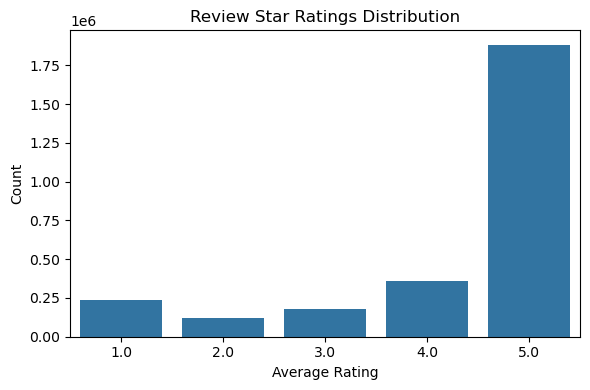

In [ ]:

ratings = (
    df_musical_verified
    .groupBy("rating")
    .agg(F.count("*").alias("count"))
    .orderBy("rating")
    .toPandas()
)

plt.figure(figsize=(6, 4))
sns.barplot(data=ratings, x="rating", y="count")
plt.title("Review Star Ratings Distribution")
plt.xlabel("Average Rating")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


This bar chart shows the number of reviews for each star rating from 1 to 5.
The distribution is highly imbalanced, with 5-star ratings making up the vast majority of reviews.
Lower ratings (1 to 3 stars) occur far less frequently, which suggests that users are more likely to leave positive reviews than negative ones.

#### 1.2.4 Correlation（high score-high number of reviews）
Finally we want to explore the potential correlation between product rating and review count.  
A random sample of the data is selected, and a scatter plot is created to visualize whether higher-rated products also tend to receive more reviews.  
This helps assess if popularity (number of reviews) is associated with better user perception (higher ratings).

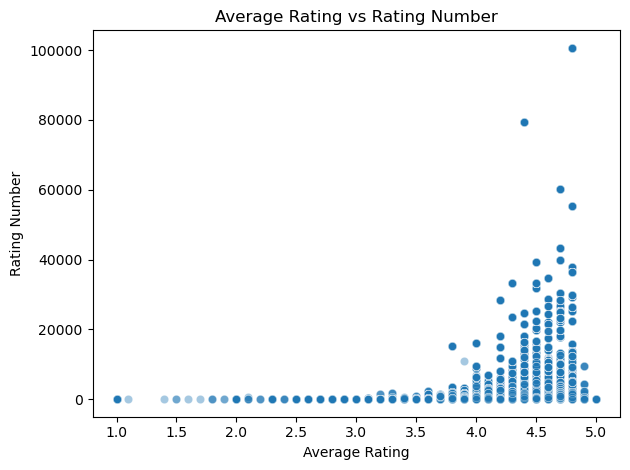

In [ ]:

df_corr = (
    df_musical_verified
    .sample(fraction=0.01, seed=42)
    .select("average_rating", "rating_number")
    .toPandas()
)

sns.scatterplot(data=df_corr, x="average_rating", y="rating_number", alpha=0.4)
plt.title("Average Rating vs Rating Number")
plt.xlabel("Average Rating")
plt.ylabel("Rating Number")
plt.tight_layout()
plt.show()



This graph illustrates the relationship between average rating and number of reviews for individual products. Each point represents a product, with its position determined by its average user rating (x-axis) and total number of reviews (y-axis). The plot shows how review volume varies across different rating levels, helping identify whether higher-rated products also tend to attract more user engagement.

### 1.3 Machine Learning

#### 1.3.1 Text Cleaning and Preparation
##### 1.3.1.1 Combine Review Title and Text

In [ ]:
df_musical_verified.columns

['parent_asin',
 'main_category',
 'title',
 'average_rating',
 'rating_number',
 'features',
 'description',
 'store',
 'categories',
 'details',
 'rating',
 'review_title',
 'text',
 'asin',
 'timestamp',
 'helpful_vote',
 'verified_purchase']

In [ ]:
combined_df = df_musical_verified.withColumn(
    "full_review",
    concat_ws(" ", coalesce(col("review_title"), lit("")), coalesce(col("text"), lit("")))
)

combined_df.show()

+-----------+--------------------+--------------------+--------------+-------------+---------------------+--------------------+--------------------+--------------------+--------------------+------+--------------------+--------------------+----------+-------------+------------+-----------------+--------------------+
|parent_asin|       main_category|               title|average_rating|rating_number|             features|         description|               store|          categories|             details|rating|        review_title|                text|      asin|    timestamp|helpful_vote|verified_purchase|         full_review|
+-----------+--------------------+--------------------+--------------+-------------+---------------------+--------------------+--------------------+--------------------+--------------------+------+--------------------+--------------------+----------+-------------+------------+-----------------+--------------------+
| B000FET3DG| Musical Instruments|Johnson BK-520-

##### 1.3.1.2 Lowercase and Clean Text

In [ ]:
cleaned_df = combined_df.withColumn(
    "clean_text",
    regexp_replace(lower(col("full_review")), "[^a-zA-Z\\s]", "")
)


##### 1.3.1.3 Tokenization and Vectorization
- **Tokenization**

In [ ]:
# Tokenize
tokenizer = RegexTokenizer(inputCol="clean_text", outputCol="tokens", pattern="\\s+")
df = tokenizer.transform(cleaned_df)


- **Generate n-grams**<br>
 We use PySpark's `NGram` to create bigrams and trigrams based on the tokenized text. This helps capture short word phrases that can be more informative than single tokens alone.

In [ ]:
# Generate n-grams (bigrams and trigrams)
bigram = NGram(n=2, inputCol="tokens", outputCol="bigrams")
df = bigram.transform(df)

In [ ]:
trigram = NGram(n=3, inputCol="tokens", outputCol="trigrams")
df = trigram.transform(df)

In [ ]:
# Combine all n-grams and tokens
df = df.withColumn("all_ngrams", F.concat_ws(" ", col("tokens"), col("bigrams"), col("trigrams")))

# Tokenize combined string back into list
tokenizer_combined = RegexTokenizer(inputCol="all_ngrams", outputCol="final_tokens", pattern="\\s+")
df = tokenizer_combined.transform(df)

**TF-IDF Vectorization**<br>
Transform the `final_tokens` into numerical feature vectors using CountVectorizer and IDF. This process helps capture the importance of terms across the corpus, resulting in the final `features_vectorized` column.

In [ ]:
# Vectorize
vectorizer = CountVectorizer(inputCol="final_tokens", outputCol="raw_features", vocabSize=5000, minDF=5)
cv_model = vectorizer.fit(df)
df = cv_model.transform(df)

idf = IDF(inputCol="raw_features", outputCol="features_vectorized")
idf_model = idf.fit(df)
df = idf_model.transform(df)

In [ ]:

# Identify defect-related reviews
defect_keywords = [
    "broken", "cracked", "shattered", "snapped", "fractured", "split open",
    "returned", "returning", "refund", "exchange", "sent back",
    "didn't work", "doesn't work", "not working", "malfunction", "faulty", "unusable", "not functional", "inoperable",
    "defective", "flawed", "manufacturing defect", "quality control issue",
    "stopped working", "quit working", "died after a week", "short lifespan", "failed to start",
    "damaged", "scratched", "dented", "chipped", "arrived broken", "arrived damaged",
    "waste of money", "not worth the price", "poor value", "rip off",
    "issue", "problem", "bug", "glitch", "technical problem", "software issue",
    "poor quality", "cheaply made", "flimsy", "low grade", "doesn't last", "worn out",
    "not as described", "misleading", "inaccurate description", "false advertising",
    "fell apart", "came apart", "came loose", "disassembled itself",
    "disappointed", "very dissatisfied", "terrible experience", "would not recommend",
    "missing parts", "incomplete", "missing accessories", "parts not included",
    "leaking", "leakage", "spilled", "seeping", "dripping",
    "error", "system error", "connection error", "installation error",
    "failed", "doesn't power on", "power failure", "boot failure", "not responding",
    "would not turn on", "won’t turn on", "no power", "stuck on loading screen",
    "overheating", "too hot", "burned", "smelled like burning",
    "battery died", "battery drained fast", "battery doesn't hold charge",
    "no sound", "audio issues", "sound not working", "silent", "muted", "speaker failure",
    "bluetooth not connecting", "wifi not working", "poor reception", "connectivity issues",
    "charging issue", "won’t charge", "charging port broken", "usb issue"
]
pattern = "|".join(defect_keywords)

defect_reviews = df.filter(col("full_review").rlike(pattern)).cache()



25/04/26 23:31:56 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


#### 1.3.2 Defect Pattern Identification
This section outlines the process of identifying defect-related reviews by converting text into vectorized features, calculating their similarity to a defect prototype using cosine similarity, and estimating the risk level of each review. It forms the core of the defect pattern recognition pipeline.

##### 1.3.2.1 Compute Semantic Center of Defect Reviews
Calculate the average TF-IDF vector of defect-related reviews to create a semantic centroid.

In [ ]:
# Map each vector to (vector, 1) and reduce to (sum_vector, count)
defect_vectors = defect_reviews.select("features_vectorized").rdd.map(lambda row: (row["features_vectorized"].toArray(), 1))

# Use reduce to sum all vectors and count
sum_vector, count = defect_vectors.reduce(
    lambda a, b: (np.add(a[0], b[0]), a[1] + b[1])
)

# Compute the mean vector
defect_mean_vector = DenseVector(sum_vector / count)

##### 1.3.2.2 Score Reviews Using Cosine Similarity
To quantify how similar each review is to the "defect profile," we compute the cosine similarity between each review vector and the average defect vector .  
We define a custom cosine similarity function and apply it to each review vector (`features_vectorized`) using PySpark UDFs. The resulting score, stored in the column `cosine_similarity_to_defect`, captures how closely the language in each review resembles known defect expressions.

In [ ]:
centroid_array = defect_mean_vector.toArray()


In [ ]:

from pyspark.sql.functions import udf
def cosine_sim(v1, v2):
    return float(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))) if np.linalg.norm(v1) != 0 and np.linalg.norm(v2) != 0 else 0.0

centroid_array = defect_mean_vector.toArray()
cosine_udf = udf(lambda v: cosine_sim(v.toArray(), centroid_array), "double")

scored_df = df.withColumn("cosine_similarity_to_defect", cosine_udf(col("features_vectorized")))


##### 1.3.2.3 Compute Weighted Similarity Score
Combine rating signals and semantic similarity into a unified weighted score for defect detection.

In [ ]:
from pyspark.sql.functions import pow

weighted_df = scored_df.withColumn(
    "weighted_similarity",
    pow((5.0 - col("rating")) / 4.0, 2) * col("cosine_similarity_to_defect")
)

##### 1.3.2.4 Thresholding and Risk Estimation

In this section, we apply a statistical threshold to identify reviews that are likely to describe product defects. Specifically, we use the 90th percentile of the `weighted_similarity` score as a cutoff—reviews with scores above this threshold are considered "risky."

In [ ]:
# Estimate a 95th percentile threshold
quantile = weighted_df.approxQuantile("weighted_similarity", [0.90], 0.01)[0]
print(f"90th percentile similarity threshold: {quantile}")
risky_reviews  = weighted_df.filter(col("weighted_similarity") >= quantile)
risky_reviews .select("title","full_review","weighted_similarity").orderBy("weighted_similarity").limit(20).toPandas()

90th percentile similarity threshold: 0.08734664044001203


,title,full_review,weighted_similarity
0,"set of 4 Guitar nuts, washers & lock washers f...",Didn’t fit! They didn’t fit my acoustic guitar.,0.087347
1,Squier by Fender Short Scale Stratocaster - Tr...,Defective piece. Two screws missing. Can’t bel...,0.087347
2,Satnam Wooden Singing Bowl Striker Mallet Beat...,No Singing with this Mallet Was not compatible...,0.087347
3,GLS Audio 12ft Mic Cable Patch Cords - XLR Mal...,One Star The manufacturer has started sending ...,0.087347
4,Vic Firth 5A Wood Tip Drumsticks - Dozen (12) ...,Not Really Vic Firths Not really Vic Firths. W...,0.087347
5,Pyle Classic Retro Dynamic Vocal Microphone - ...,It's pretty bad (as in bad) Noisy (even with a...,0.087347
6,"GLS Audio 6ft Patch Cable Cords - 1/4"" TRS to ...",4 out of 6 So 2 out of 6 cables was DOA. I me...,0.087347
7,Neewer Professional Microphone Pop Filter Shie...,Unstable and unreliable. Not sure why but this...,0.087347
8,Violin Model 100 with Solid Wood 4/4 Full Size...,Tune Problems I think it would be unfair for m...,0.087347
9,Biyang Acoustic Guitar Stand Wangs Mini 5,This amp will die. Smelled like burning paint....,0.087348


In [ ]:
# Risky review count per product
risky_count_df = risky_reviews .groupBy("asin","title").agg(count("*").alias("risky_count"))

# Total review count per product
total_count_df = weighted_df.groupBy("asin","title").agg(count("*").alias("total_count"))

In [ ]:
# Join and calculate risky review percentage
risky_percent_df = risky_count_df.join(total_count_df, on=["asin","title"]) \
    .withColumn("risky_percent", round((col("risky_count") / col("total_count")) * 100, 2))

In [ ]:
risky_percent_df.select("asin","title", "risky_count", "total_count", "risky_percent").orderBy("risky_count",ascending=False).show()


+----------+--------------------+-----------+-----------+-------------+
|      asin|               title|risky_count|total_count|risky_percent|
+----------+--------------------+-----------+-----------+-------------+
|B00DY1F2CS|Neewer Microphone...|        759|       4790|        15.85|
|B07WLWN2ZT|TONOR USB Microph...|        531|       2465|        21.54|
|B016C4ZG74|PoP voice Profess...|        512|       3167|        16.17|
|B00KMF11BA|GoDpsMusic Music ...|        451|       2444|        18.45|
|B0007L8BQW|PYLE-PRO Wireless...|        446|       1148|        38.85|
|B000XI6O2W|Singing Machine S...|        405|       2436|        16.63|
|B07L5B64RG|Getaria Upgrade 2...|        400|       2821|        14.18|
|B0049J4O0K|Best Choice Produ...|        389|       1670|        23.29|
|B003LPTAYI|Sennheiser HD 202...|        388|       4395|         8.83|
|B01H74YV56|Snark SN5X Clip-O...|        378|       4730|         7.99|
|B0002E1G5C|D'Addario Pro-Win...|        366|       2921|       

##### 1.3.2.5 Similarity Distribution Analysis
To better understand the distribution of reviews based on their similarity to known defect cases, we create a new column called `similarity_bracket`. This column segments the `weighted_similarity` scores into buckets .  
By grouping and counting the number of reviews in each bracket, we can visualize how reviews cluster in terms of similarity—this helps reveal whether defect-like reviews are concentrated in specific score ranges.

In [ ]:
# Create bracket column
weighted_df = weighted_df.withColumn(
    "similarity_bracket",
    when(col("weighted_similarity") < 0.1, "0.0–0.1") \
    .when(col("weighted_similarity") < 0.2, "0.1–0.2") \
    .when(col("weighted_similarity") < 0.3, "0.2–0.3") \
    .when(col("weighted_similarity") < 0.4, "0.3–0.4") \
    .when(col("weighted_similarity") < 0.5, "0.4–0.5") \
    .when(col("weighted_similarity") < 0.6, "0.5–0.6") \
    .when(col("weighted_similarity") < 0.7, "0.6–0.7") \
    .when(col("weighted_similarity") < 0.8, "0.7–0.8") \
    .when(col("weighted_similarity") < 0.9, "0.8–0.9") \
    .otherwise("0.9–1.0")
)

# Group by bracket and count
bracket_counts = weighted_df.groupBy("similarity_bracket").count().orderBy("similarity_bracket")
bracket_counts.show()


+------------------+-------+
|similarity_bracket|  count|
+------------------+-------+
|           0.0–0.1|2523774|
|           0.1–0.2| 173821|
|           0.2–0.3|  66776|
|           0.3–0.4|  14184|
|           0.4–0.5|   1787|
|           0.5–0.6|    164|
|           0.6–0.7|      9|
+------------------+-------+



The results show a steep drop in the number of reviews as the similarity score increases:

The vast majority of reviews (over 2.5 million) fall into the 0.0–0.1 similarity bracket, meaning they are very dissimilar to the defect-related review centroid.
Only 173k reviews fall in the 0.1–0.2 range.Fewer than 10 reviews fall into the 0.6–0.7 range.


Most user reviews do not resemble defect-related content, suggesting that defect-type language is relatively rare in the dataset. This distribution highlights the effectiveness of using cosine similarity to distinguish between typical and potentially risky reviews.

#### 1.3.3 Risky Product & Store Detection
##### 1.3.3.1 Identify Defective Products

In [ ]:
defective_products_df = risky_percent_df.filter(
    (col("risky_percent") >= 20) & (col("total_count") >= 10)
).select("asin").distinct()
defective_products_df.count()

7530

In [ ]:
defective_reviews = weighted_df.join(defective_products_df, on="asin", how="inner")


##### 1.3.3.2 Store-wise Summary and Filtering

This section calculates and ranks stores based on their proportion of defective products.

First, counts how many distinct defective products each store is associated wit

In [ ]:
store_defect_counts = defective_reviews.select("asin", "store").distinct() \
    .groupBy("store").count() \
    .withColumnRenamed("count", "defective_products") \
    .orderBy(col("defective_products").desc())


Then, it calculates the total number of distinct products sold per store.

In [ ]:
total_products_per_store = weighted_df.select("asin", "store").distinct() \
    .groupBy("store").count().withColumnRenamed("count", "total_products")

Finally, it joins both results to compute the percentage of defective products per store, helping identify stores with higher risk profiles for product quality.

In [ ]:
store_summary = total_products_per_store.join(store_defect_counts, on="store", how="left") \
    .fillna(0, subset=["defective_products"]) \
    .withColumn("defective_percent", round((col("defective_products") / col("total_products")) * 100, 2)) \
    .orderBy(col("defective_products").desc())


In [ ]:
store_summary.show()

+--------------------+--------------+------------------+-----------------+
|               store|total_products|defective_products|defective_percent|
+--------------------+--------------+------------------+-----------------+
|                Pyle|          1001|               197|            19.68|
|              Fender|          4996|                95|              1.9|
|           Musiclily|          1916|                74|             3.86|
|  Mendini by Cecilio|           330|                68|            20.61|
|              Neewer|           659|                57|             8.65|
|           Behringer|           855|                53|              6.2|
|              Donner|           685|                48|             7.01|
|           D'Addario|          1918|                46|              2.4|
|             Cecilio|           389|                45|            11.57|
|Best Choice Products|           133|                45|            33.83|
|           Rockville|   

We filter the store_summary DataFrame to highlight only those stores where more than 30% of their listed products are defective.
This helps surface vendors with disproportionately high defect rates, which could signal issues in quality control, sourcing, or product integrity.

In [ ]:
store_summary.filter(col("defective_percent") > 30).show()

+--------------------+--------------+------------------+-----------------+
|               store|total_products|defective_products|defective_percent|
+--------------------+--------------+------------------+-----------------+
|Best Choice Products|           133|                45|            33.83|
|             RockJam|            70|                23|            32.86|
|          Fstop Labs|            73|                23|            31.51|
|         Karaoke USA|            41|                15|            36.59|
|             ZINGYOU|            31|                15|            48.39|
|             MASINGO|            42|                14|            33.33|
|            HPKL9999|            20|                13|             65.0|
|          ChordBuddy|            34|                12|            35.29|
|             XIN&LOG|            23|                11|            47.83|
|             XIAOKOA|            25|                10|             40.0|
|           Shop4Omni|   

This table shows the top stores with the highest defect rates. For instance, HPKL9999 and Shop4Omni have over 60% defective products, while larger brands like Best Choice Products also exceed 35%. Both small and big stores show quality concerns.

In [ ]:
store_summary.count()

25108

##### 1.3.3.3 Flag High-Risk Stores for Investigation
In this step, we filter for stores that have both a sufficiently large number of products (≥10) and a high defect rate (≥10%). This allows us to flag high-risk stores that might warrant further investigation or quality control checks.

In [ ]:
flagged_stores = store_summary.filter(
    (col("total_products") >= 10) & (col("defective_percent") >= 10)
).orderBy(["defective_percent"],ascending=False)
flagged_stores.show()

+--------------------+--------------+------------------+-----------------+
|               store|total_products|defective_products|defective_percent|
+--------------------+--------------+------------------+-----------------+
|            HPKL9999|            20|                13|             65.0|
|           Shop4Omni|            13|                 8|            61.54|
|             ZINGYOU|            31|                15|            48.39|
|             XIN&LOG|            23|                11|            47.83|
|               Razer|            13|                 6|            46.15|
|            fotowelt|            11|                 5|            45.45|
|                Teac|            12|                 5|            41.67|
|                Star|            15|                 6|             40.0|
|             XIAOKOA|            25|                10|             40.0|
|         CHANGYANGWU|            13|                 5|            38.46|
|             Windsor|   

These results highlight stores with a high proportion of defective products. Such vendors may warrant closer inspection or intervention, especially those with a defect rate exceeding 50%.

#### 1.3.4 Visualizations


##### 1.3.4.1 Top-defect Stores in 5 Most Reviewed Categories

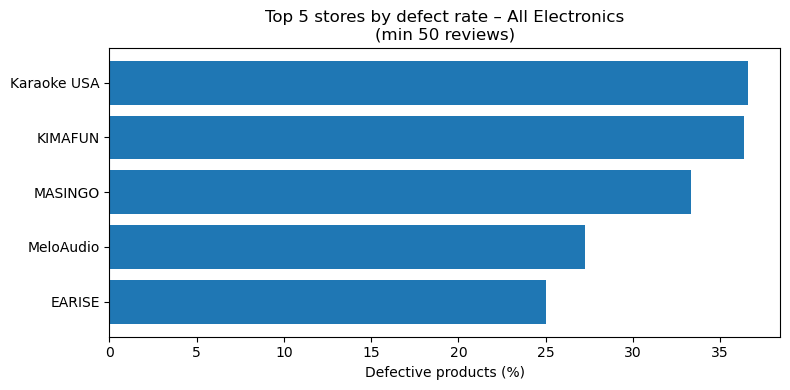

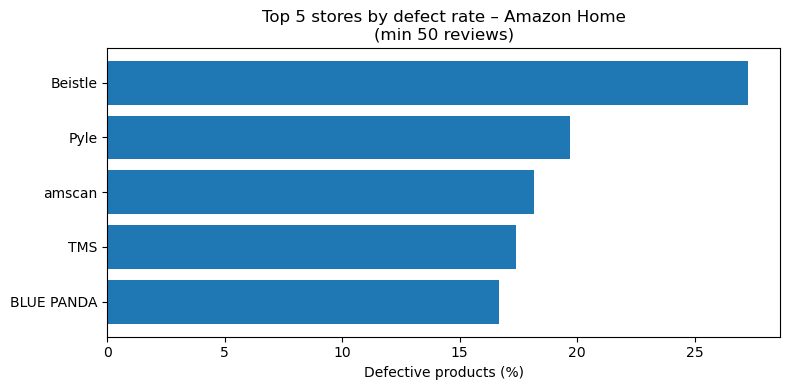

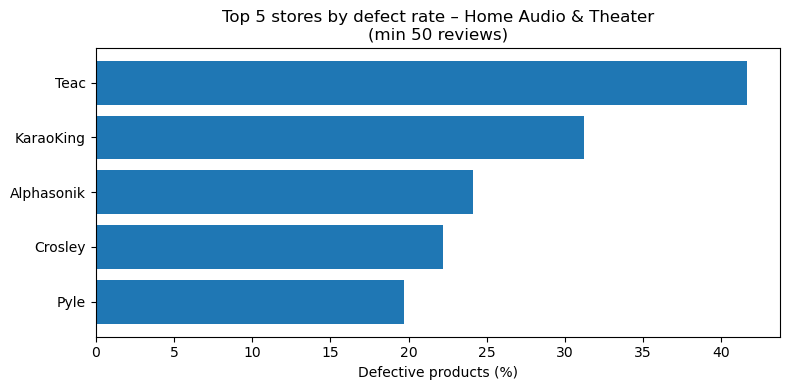

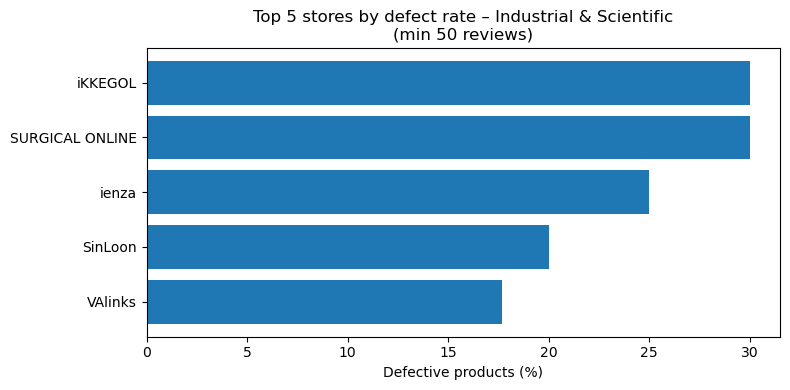

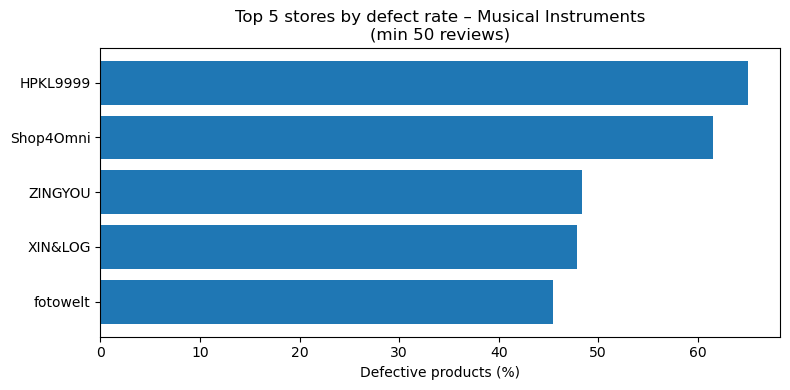

In [ ]:
# parameters
TOP_N       = 5      # show top-N stores per category
MIN_PRODS   = 10     # ignore stores with fewer than this many total products
MAX_CATS    = 5     # limit to this many most-reviewed categories
MIN_REVIEWS = 50     # minimum # of reviews for the store in that category

# Most-reviewed categories
popular_cats = (weighted_df
                .groupBy("main_category")
                .agg(F.count("*").alias("n_reviews"))
                .orderBy(F.desc("n_reviews"))
                .limit(MAX_CATS)
                .select("main_category"))

# Every (category, store) pair in those categories + review count
cat_store_pairs = (weighted_df
                   .join(popular_cats, on="main_category")
                   .groupBy("main_category", "store")
                   .agg(F.count("*").alias("review_count"))
                   .filter(F.col("review_count") >= MIN_REVIEWS))

# Bring in pre-computed defective_percent & total_products
cat_store_defect = (cat_store_pairs
                    .join(store_summary      # has defective_percent / total_products
                          .select("store",
                                  "defective_percent",
                                  "total_products"),
                          on="store")
                    .filter(F.col("total_products") >= MIN_PRODS))

# Top-N stores inside each category
w = Window.partitionBy("main_category").orderBy(F.desc("defective_percent"))
top_stores_per_cat = (cat_store_defect
                      .withColumn("rk", F.row_number().over(w))
                      .filter(F.col("rk") <= TOP_N)
                      .orderBy("main_category", "rk"))

# Collect & plot
pdf = top_stores_per_cat.toPandas()

for cat in pdf["main_category"].unique():
    sub = pdf.loc[pdf["main_category"] == cat] \
             .sort_values("defective_percent", ascending=True)

    plt.figure(figsize=(8, 4))
    plt.barh(sub["store"], sub["defective_percent"])
    plt.xlabel("Defective products (%)")
    plt.title(f"Top {TOP_N} stores by defect rate – {cat}\n(min {MIN_REVIEWS} reviews)")
    plt.tight_layout()
    plt.show()

The visualization highlights the top five stores with the highest product defect rates across several categories, based on a minimum of 50 reviews. In the All Electronics category, stores like Karaoke USA and KIMAFUN report defect rates close to 37%, while Amazon Home stores show slightly lower rates, with Beslite leading at around 27%. In Home Audio & Theater, Teac and KaraokeKing exhibit the highest defect rates, reaching nearly 40%. For Industrial & Scientific, iKKEGOL and SURGICAL ONLINE have defect rates close to 29%. Notably, the Musical Instruments category stands out with extremely high defect rates, where HRPKL599 and Shop4Omni exceed 59%, indicating significant quality issues in that segment. Overall, while defect rates vary by category, Musical Instruments and Home Audio products tend to have the highest rates of defective products among top stores.

##### 1.3.4.2 Defective Product Rate By Category

In [ ]:
category_defect_rate = (risky_reviews
                        .groupBy("main_category")
                        .agg(F.count("*").alias("defect_count"))
                        .join(weighted_df.groupBy("main_category").agg(F.count("*").alias("total_reviews")), on="main_category")
                        .withColumn("avg_defect_rate", (F.col("defect_count") / F.col("total_reviews")) * 100)
                        .orderBy("avg_defect_rate", ascending=False)
                        )

# Convert to pandas
category_defect_pd = category_defect_rate.toPandas()

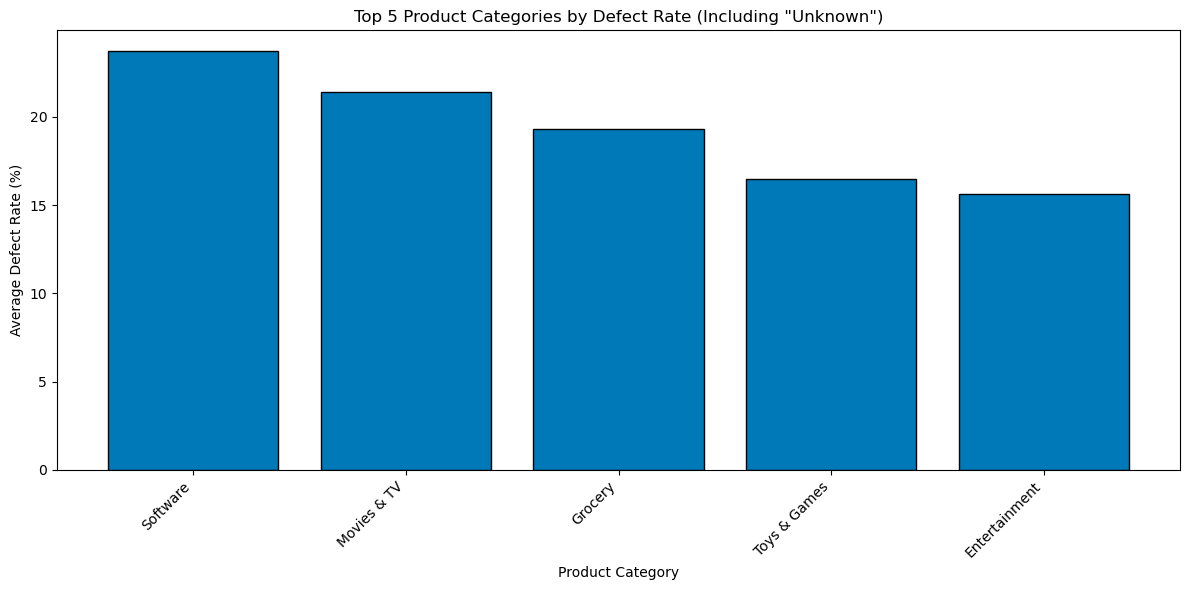

In [ ]:
# Fill missing category names
category_defect_pd['main_category'] = category_defect_pd['main_category'].fillna('Unknown')

# Sort and select top 10 categories by defect rate
top10_categories = category_defect_pd.sort_values(by='avg_defect_rate', ascending=False).head(5)

# Plotting
plt.figure(figsize=(12,6))
bars = plt.bar(
    top10_categories['main_category'],
    top10_categories['avg_defect_rate'],
    color='#0079B8',          # Specific blue you provided
    edgecolor='black'         # Black border for neatness
)

plt.xticks(rotation=45, ha='right')
plt.xlabel('Product Category')
plt.ylabel('Average Defect Rate (%)')
plt.title('Top 5 Product Categories by Defect Rate (Including "Unknown")')

plt.tight_layout()
plt.show()


This bar chart presents the top five product categories with the highest average defect rates, including entries labeled as "Unknown." Software tops the list with the highest defect rate, slightly above 22%, followed by Movies & TV and Grocery, both hovering around 20%. Toys & Games and Entertainment complete the top five, with defect rates ranging from approximately 16% to 18%. The results suggest that digital and media-related categories, along with consumables like groceries, face higher quality issues compared to other product categories.

## 2. Appliances


### 2.1 Data Loading and Preprocessing
1. Meta Data<br>
The schema ensures proper data types for each column.

In [ ]:
schema = StructType([
    StructField("main_category", StringType(), True),
    StructField("title", StringType(), True),
    StructField("average_rating", FloatType(), True),
    StructField("rating_number", IntegerType(), True),
    StructField("features", StringType(), True),
    StructField("description", StringType(), True),
    StructField("price", StringType(), True),
    StructField("images", StringType(), True),
    StructField("videos", StringType(), True),
    StructField("store", StringType(), True),
    StructField("categories", StringType(), True),
    StructField("details", StringType(), True),
    StructField("parent_asin", StringType(), True),
    StructField("bought_together", StringType(), True),
    StructField("subtitle", StringType(), True),
    StructField("author", StringType(), True)
])
gcs_path = "gs://amazon-review-project/project/appliance_meta.csv"

df_appliances_meta = spark.read.csv(
    gcs_path,
    header=True,
    schema=schema,
    multiLine=True,
    escape='"'
)

df_appliances_meta.show(5)


+--------------------+--------------------+--------------+-------------+---------------------+--------------------+-----+--------------------+--------------------+---------+--------------------+--------------------+-----------+---------------+--------+------+
|       main_category|               title|average_rating|rating_number|             features|         description|price|              images|              videos|    store|          categories|             details|parent_asin|bought_together|subtitle|author|
+--------------------+--------------------+--------------+-------------+---------------------+--------------------+-----+--------------------+--------------------+---------+--------------------+--------------------+-----------+---------------+--------+------+
|Industrial & Scie...|ROVSUN Ice Maker ...|           3.7|           61|['【Quick Ice Maki...|                  []| NULL|[{'thumb': 'https...|[{'title': 'Our P...|   ROVSUN|['Appliances', 'R...|{'Brand': 'ROVSUN...| B08Z7

Then convert the first 5 rows of the Spark DataFrame to a Pandas DataFrame for easier preview and interaction.

In [ ]:
df_appliances_meta.limit(5).toPandas()

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author
0,Industrial & Scientific,"ROVSUN Ice Maker Machine Countertop, Make 44lb...",3.7,61,['【Quick Ice Making】This countertop ice machin...,[],None,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Our Point of View on the Euhomy Ic...,ROVSUN,"['Appliances', 'Refrigerators, Freezers & Ice ...","{'Brand': 'ROVSUN', 'Model Name': 'ICM-2005', ...",B08Z743RRD,None,None,None
1,Tools & Home Improvement,"HANSGO Egg Holder for Refrigerator, Deviled Eg...",4.2,75,"['Plastic', 'Practical Kitchen Storage - Our e...",[],None,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': '10 Eggs Egg Holder for Refrigerato...,HANSGO,"['Appliances', 'Parts & Accessories', 'Refrige...","{'Manufacturer': 'HANSGO', 'Part Number': 'HAN...",B097BQDGHJ,None,None,None
2,Tools & Home Improvement,"Clothes Dryer Drum Slide, General Electric, Ho...",3.5,18,[],"['Brand new dryer drum slide, replaces General...",None,[{'thumb': 'https://m.media-amazon.com/images/...,[],GE,"['Appliances', 'Parts & Accessories']","{'Manufacturer': 'RPI', 'Part Number': 'WE1M33...",B00IN9AGAE,None,None,None
3,Tools & Home Improvement,154567702 Dishwasher Lower Wash Arm Assembly f...,4.5,26,['MODEL NUMBER:154567702 Dishwasher Lower Wash...,['MODEL NUMBER:154567702 Dishwasher Lower Wash...,None,[{'thumb': 'https://m.media-amazon.com/images/...,[],folosem,"['Appliances', 'Parts & Accessories', 'Dryer P...","{'Manufacturer': 'folosem', 'Part Number': '15...",B0C7K98JZS,None,None,None
4,Tools & Home Improvement,Whirlpool W10918546 Igniter,3.8,12,['This is a Genuine OEM Replacement Part.'],['Whirlpool Igniter'],25.07,[{'thumb': 'https://m.media-amazon.com/images/...,[],Whirlpool,"['Appliances', 'Parts & Accessories']","{'Manufacturer': 'Whirlpool', 'Part Number': '...",B07QZHQTVJ,None,None,None


Display all available columns in the dataset, then select only the relevant fields for analysis, including category, ratings, and product details.

In [ ]:
df_appliances_meta.columns

['main_category',
 'title',
 'average_rating',
 'rating_number',
 'features',
 'description',
 'price',
 'images',
 'videos',
 'store',
 'categories',
 'details',
 'parent_asin',
 'bought_together',
 'subtitle',
 'author']

In [ ]:
df_appliances_meta=df_appliances_meta.select('main_category',
 'title',
 'average_rating',
 'rating_number',
 'features',
 'description',
 'store',
 'categories',
 'details',
 'parent_asin')
df_appliances_meta.limit(5).toPandas()

,main_category,title,average_rating,rating_number,features,description,store,categories,details,parent_asin
0,Industrial & Scientific,"ROVSUN Ice Maker Machine Countertop, Make 44lb...",3.7,61,['【Quick Ice Making】This countertop ice machin...,[],ROVSUN,"['Appliances', 'Refrigerators, Freezers & Ice ...","{'Brand': 'ROVSUN', 'Model Name': 'ICM-2005', ...",B08Z743RRD
1,Tools & Home Improvement,"HANSGO Egg Holder for Refrigerator, Deviled Eg...",4.2,75,"['Plastic', 'Practical Kitchen Storage - Our e...",[],HANSGO,"['Appliances', 'Parts & Accessories', 'Refrige...","{'Manufacturer': 'HANSGO', 'Part Number': 'HAN...",B097BQDGHJ
2,Tools & Home Improvement,"Clothes Dryer Drum Slide, General Electric, Ho...",3.5,18,[],"['Brand new dryer drum slide, replaces General...",GE,"['Appliances', 'Parts & Accessories']","{'Manufacturer': 'RPI', 'Part Number': 'WE1M33...",B00IN9AGAE
3,Tools & Home Improvement,154567702 Dishwasher Lower Wash Arm Assembly f...,4.5,26,['MODEL NUMBER:154567702 Dishwasher Lower Wash...,['MODEL NUMBER:154567702 Dishwasher Lower Wash...,folosem,"['Appliances', 'Parts & Accessories', 'Dryer P...","{'Manufacturer': 'folosem', 'Part Number': '15...",B0C7K98JZS
4,Tools & Home Improvement,Whirlpool W10918546 Igniter,3.8,12,['This is a Genuine OEM Replacement Part.'],['Whirlpool Igniter'],Whirlpool,"['Appliances', 'Parts & Accessories']","{'Manufacturer': 'Whirlpool', 'Part Number': '...",B07QZHQTVJ


2. Reviews<br>
The schema includes fields such as rating, review text, product ID, and user info.


In [ ]:
schema_reviews = StructType([
    StructField("rating", FloatType(), True),
    StructField("title", StringType(), True),
    StructField("text", StringType(), True),
    StructField("images", StringType(), True),
    StructField("asin", StringType(), True),
    StructField("parent_asin", StringType(), True),
    StructField("user_id", StringType(), True),
    StructField("timestamp", StringType(), True),
    StructField("helpful_vote", IntegerType(), True),
    StructField("verified_purchase", StringType(), True)
])
gcs_path = "gs://amazon-review-project/project/appliances_reviews.csv"

df_appliances_reviews = spark.read.csv(
    gcs_path,
    header=True,
    schema=schema_reviews,
    multiLine=True,
    escape='"'
)

df_appliances_reviews = df_appliances_reviews.withColumnRenamed("title", "review_title")

df_appliances_reviews.show(5)


+------+-----------------+--------------------+------+----------+-----------+--------------------+-------------+------------+-----------------+
|rating|     review_title|                text|images|      asin|parent_asin|             user_id|    timestamp|helpful_vote|verified_purchase|
+------+-----------------+--------------------+------+----------+-----------+--------------------+-------------+------------+-----------------+
|   5.0|       Work great|work great. use a...|    []|B01N0TQ0OH| B01N0TQ0OH|AGKHLEW2SOWHNMFQI...|1519317108692|           0|             True|
|   5.0|excellent product|Little on the thi...|    []|B07DD2DMXB| B07DD37QPZ|AHWWLSPCJMALVHDDV...|1664746863446|           0|             True|
|   5.0|  Happy customer!|Quick delivery, f...|    []|B082W3Z9YK| B082W3Z9YK|AHZIJGKEWRTAEOZ67...|1607225435363|           0|             True|
|   5.0|    Amazing value|I wasn't sure whe...|    []|B078W2BJY8| B078W2BJY8|AFGUPTDFAWOHHL4LZ...|1534104184306|           0|           

List all columns in the review dataset, then retain only selected fields related to review content, product ID, user info, and review for further analysis.

In [ ]:
df_appliances_reviews.columns

['rating',
 'review_title',
 'text',
 'images',
 'asin',
 'parent_asin',
 'user_id',
 'timestamp',
 'helpful_vote',
 'verified_purchase']

In [ ]:
df_appliances_reviews=df_appliances_reviews.select('rating',
 'review_title',
 'text',
 'asin',
 'parent_asin',
 'timestamp',
 'helpful_vote',
 'verified_purchase')

In [ ]:
df_appliances_reviews.limit(5).toPandas()

,rating,review_title,text,asin,parent_asin,timestamp,helpful_vote,verified_purchase
0,5.0,Work great,work great. use a new one every month,B01N0TQ0OH,B01N0TQ0OH,1519317108692,0,True
1,5.0,excellent product,Little on the thin side,B07DD2DMXB,B07DD37QPZ,1664746863446,0,True
2,5.0,Happy customer!,"Quick delivery, fixed the issue!",B082W3Z9YK,B082W3Z9YK,1607225435363,0,True
3,5.0,Amazing value,I wasn't sure whether these were worth it or n...,B078W2BJY8,B078W2BJY8,1534104184306,0,True
4,5.0,Dryer parts,Easy to install got the product expected to re...,B08C9LPCQV,B08C9LPCQV,1620176603754,0,True


Join the metadata and review datasets using the shared parent_asin key. Then filter and clean the columns.

In [ ]:
df_app_joined = df_appliances_meta.join(df_appliances_reviews, on = 'parent_asin', how= 'right')


In [ ]:
df_app_verified  = df_app_joined.filter(F.col("verified_purchase") == True)

In [ ]:
df_app_verified = df_app_verified.withColumn("description", when(col("description") == "[]", None).otherwise(col("description")))
df_app_verified = df_app_verified.withColumn("features", when(col("features") == "[]", None).otherwise(col("features")))
df_app_verified = df_app_verified.withColumn("categories", when(col("categories") == "[]", None).otherwise(col("categories")))


In [ ]:
df_app_verified.limit(5).toPandas().head()

,parent_asin,main_category,title,average_rating,rating_number,features,description,store,categories,details,rating,review_title,text,asin,timestamp,helpful_vote,verified_purchase
0,B01N0TQ0OH,Tools & Home Improvement,Geesta 12-Pack Premium Activated Charcoal Wate...,4.7,4939,"['EXCEPTIONAL QUALITY AND VALUE: Brew clean, d...",None,Geesta,"['Small Appliance Parts & Accessories', 'Coffe...","{'Manufacturer': 'Geesta', 'Part Number': 'Gee...",5.0,Work great,work great. use a new one every month,B01N0TQ0OH,1519317108692,0,True
1,B07DD37QPZ,Tools & Home Improvement,Essential Values 18 Pack Compatible Replacemen...,4.4,3186,['BEST VALUE - Our 18 Pack Of Fine Polyester R...,None,Essential Values,"['Appliances', 'Parts & Accessories', 'Dryer P...","{'Manufacturer': 'Essential Values', 'Part Num...",5.0,excellent product,Little on the thin side,B07DD2DMXB,1664746863446,0,True
2,B078W2BJY8,Amazon Home,"Filterlogic UKF8001 Water Filter, Replacement ...",4.6,355,['The replacement for Maytag UKF8001 refrigera...,['FilterLogic FL-RF13 Replacement Refrigerator...,FilterLogic,"['Appliances', 'Parts & Accessories', 'Refrige...","{'Material': 'Carbon,Coconut Shell', 'Product ...",5.0,Amazing value,I wasn't sure whether these were worth it or n...,B078W2BJY8,1534104184306,0,True
3,B082W3Z9YK,Tools & Home Improvement,279838 Dryer Heating Element by Romalon with R...,4.5,444,"[""★【BUY WITH CONFIDENCE】 For any reason you're...",None,Romalon,"['Appliances', 'Parts & Accessories', 'Dryer P...","{'Manufacturer': 'Romalon', 'Part Number': '27...",5.0,Happy customer!,"Quick delivery, fixed the issue!",B082W3Z9YK,1607225435363,0,True
4,B08C9LPCQV,Tools & Home Improvement,Sikawai 279816 Dryer Thermal Cut-off Kit Repla...,4.4,55,None,None,Sikawai,"['Appliances', 'Parts & Accessories', 'Dryer P...","{'Part Number': '279816', 'Item Weight': '1.8 ...",5.0,Dryer parts,Easy to install got the product expected to re...,B08C9LPCQV,1620176603754,0,True


### 2.2 Exploratory Data Analysis(EDA) and Data Visualization
Check the schema of the cleaned DataFrame to confirm column names and data types.

In [ ]:
# Basic information
df_app_verified.printSchema()

root
 |-- parent_asin: string (nullable = true)
 |-- main_category: string (nullable = true)
 |-- title: string (nullable = true)
 |-- average_rating: float (nullable = true)
 |-- rating_number: integer (nullable = true)
 |-- features: string (nullable = true)
 |-- description: string (nullable = true)
 |-- store: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- details: string (nullable = true)
 |-- rating: float (nullable = true)
 |-- review_title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- helpful_vote: integer (nullable = true)
 |-- verified_purchase: string (nullable = true)



In [ ]:
df_app_verified.count()

2040064

In [ ]:
df_app_verified.groupBy('rating').count().show()

+------+-------+
|rating|  count|
+------+-------+
|   1.0| 227691|
|   5.0|1442455|
|   2.0|  74039|
|   4.0| 197696|
|   3.0|  98183|
+------+-------+



#### 2.2.1 Top 20 Categories by Customer Reviews

Group the data by main_category, count the number of reviews, calcuate average rating in each. Sort the result in descending order to identify the most reviewed product categories.


,main_category,Review Count,Average Rating
0,Tools & Home Improvement,761473,4.324147
1,Amazon Home,555137,4.259370
2,Appliances,553352,4.163137
3,Industrial & Scientific,94259,4.157301
4,None,26675,4.180319
5,Grocery,11256,4.283493
6,Automotive,8202,4.223848
7,Health & Personal Care,7196,4.173569
8,Sports & Outdoors,4592,4.253920
9,Baby,3614,4.051190


/tmp/ipykernel_12476/3055567024.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=category_df, x="Review Count", y="main_category", palette="viridis")


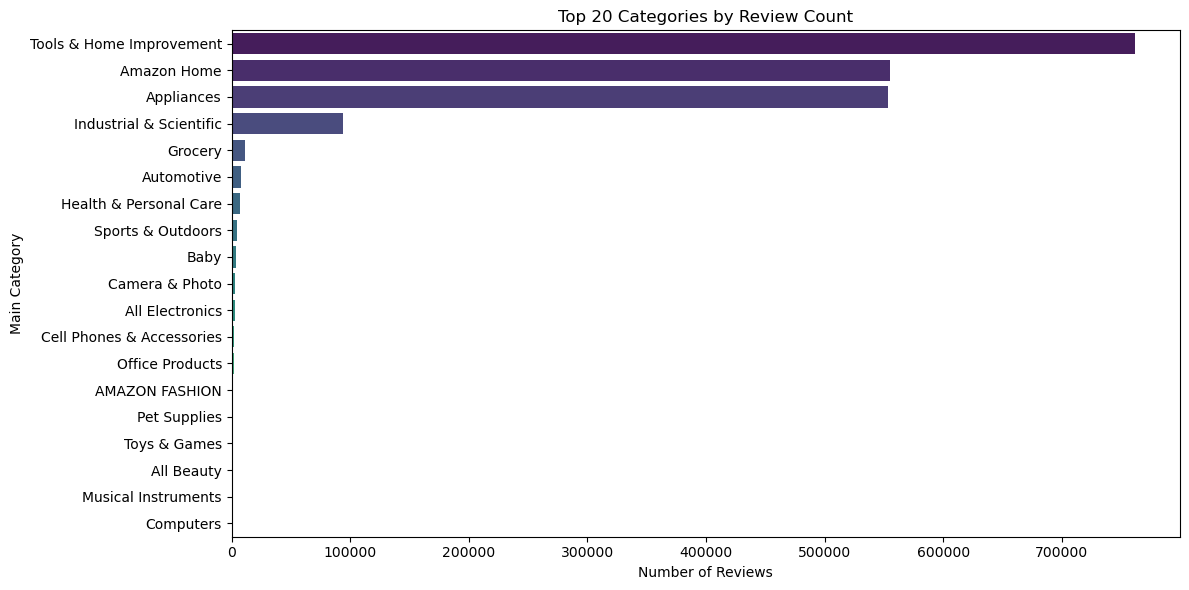

In [ ]:
# Total reviews and average rating by category
df_category_summary = df_app_verified.groupBy("main_category") \
    .agg(
        F.count("*").alias("Review Count"),
        F.avg("rating").alias("Average Rating")
    ) \
    .orderBy(F.desc("Review Count"))

# Convert to Pandas for visualization
category_df = df_category_summary.limit(20).toPandas()
display (category_df)

plt.figure(figsize=(12, 6))
sns.barplot(data=category_df, x="Review Count", y="main_category", palette="viridis")
plt.title("Top 20 Categories by Review Count")
plt.xlabel("Number of Reviews")
plt.ylabel("Main Category")
plt.tight_layout()
plt.show()

This highlights the top 20 product categories by review count in the dataset. Tools & Home Improvement, Amazon Home, and Appliances dominate in volume, each with over 500,000 reviews. While these categories show strong customer engagement, their average ratings fall between 4.16 and 4.32, suggesting generally positive but not exceptional satisfaction. In contrast, niche categories like Office Products, Musical Instruments, and All Beauty receive far fewer reviews but stand out with notably high average ratings—above 4.35 in all three cases. This indicates that smaller, more specialized product categories may have higher product-market fit or more consistent customer satisfaction.

#### 2.2.2 Rating Distribution Analysis

This visualization highlights rating patterns from 10,000 verified reviews to reveal satisfaction trends and potential biases.

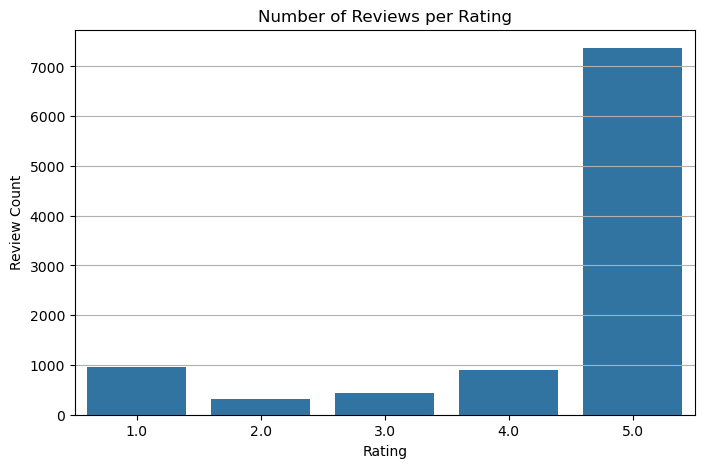

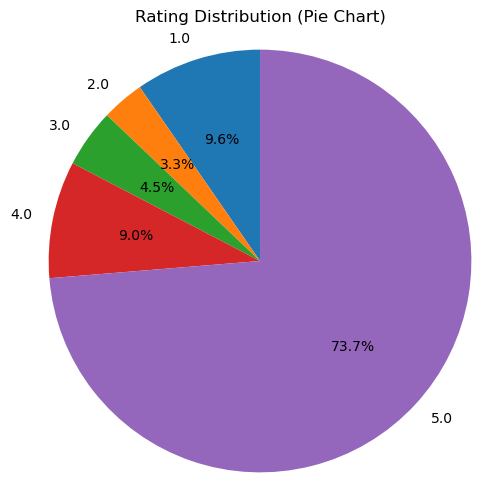

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sample from Spark DataFrame (if not already done)
sample_df = df_app_verified.select("rating", "helpful_vote", "store", "main_category") \
                           .dropna() \
                           .limit(10000) \
                           .toPandas()

# Distribution of Ratings
plt.figure(figsize=(8, 5))
sns.countplot(x="rating", data=sample_df, order=sorted(sample_df["rating"].unique()))
plt.title("Number of Reviews per Rating")
plt.xlabel("Rating")
plt.ylabel("Review Count")
plt.grid(axis="y")
plt.show()

# Rating counts for Pie Chart
rating_counts = sample_df["rating"].value_counts().sort_index()

plt.figure(figsize=(6, 6))
plt.pie(rating_counts, labels=rating_counts.index, autopct="%1.1f%%", startangle=90)
plt.title("Rating Distribution (Pie Chart)")
plt.axis("equal")
plt.show()

Both the bar chart and pie chart clearly reveal a strong positive skew in customer sentiment. A significant majority of reviews — approximately 74% — are 5-star ratings, indicating high overall satisfaction among verified purchasers. In contrast, lower ratings (1 to 3 stars) collectively account for a much smaller share, with 1-star ratings at about 9.6%, and 2- and 3-star reviews contributing even less.

#### 2.2.3 Top 10 Most Reviewed Products

Ranking the most reviewed appliances by customer count and highlighting their average Rating scores.

In [ ]:
# Most Reviewed Products
top_products = df_app_verified.groupBy("title", "main_category", "store") \
    .agg(
        F.count("*").alias("Review Count"),
        F.avg("rating").alias("Average Rating")
    ) \
    .orderBy(F.desc("Review Count")) \
    .limit(10)

top_products.toPandas()

,title,main_category,store,Review Count,Average Rating
0,12 Pack Keurig Filter Replacement by K&J - Com...,Amazon Home,K&J,11865,4.862958
1,iPartPlusMore Reusable Coffee Filters Compatib...,Amazon Home,iPartsPlusMore,11416,4.160039
2,Linda's Essentials Silicone Stove Gap Covers (...,Amazon Home,Linda's Essentials,8412,4.497979
3,SAMSUNG Genuine Filters for Refrigerator Water...,Tools & Home Improvement,SAMSUNG,7195,4.343711
4,GE MWF Refrigerator Water Filter | Certified t...,Tools & Home Improvement,GE,6876,4.341623
5,K&J 12-Pack of Cuisinart Compatible Replacemen...,Amazon Home,K&J,6071,4.847142
6,everydrop by Whirlpool Ice and Water Refrigera...,Appliances,EveryDrop by Whirlpool,5782,4.092874
7,KITCHEN BASICS 101 WB31M20 and WB31M19 Replace...,Tools & Home Improvement,KITCHEN BASICS 101,5625,4.084089
8,Best GE MWF Refrigerator Water Filter Smartwat...,Amazon Home,Best,5231,4.554387
9,Frigidaire WF3CB Puresource3 Refrigerator Wate...,Appliances,Frigidaire,5171,4.302456


This table presents the top 10 most reviewed products in the dataset, grouped by product title, category, and store. The most reviewed item is the 12 Pack Keurig Filter Replacement from K&J, receiving nearly 12,000 reviews with an impressive average rating of 4.86. Other highly reviewed items include products from iPartsPlusMore, GE, Whirlpool, and Frigidaire—many of which are water filters and replacement components for popular home appliances.

Most of the top products maintain strong customer ratings, with several scoring above 4.5, indicating consistent user satisfaction despite high review volumes. Even lower-rated items in the list, such as everydrop by Whirlpool, still maintain ratings above 4.0, reflecting generally favorable customer feedback.

#### 2.2.4 Top 10 Stores by Number of Reviews

Highlighting the most reviewed appliance brands across verified customer reviews.

Text(0.5, 1.0, 'Top 10 Stores by Review Count')

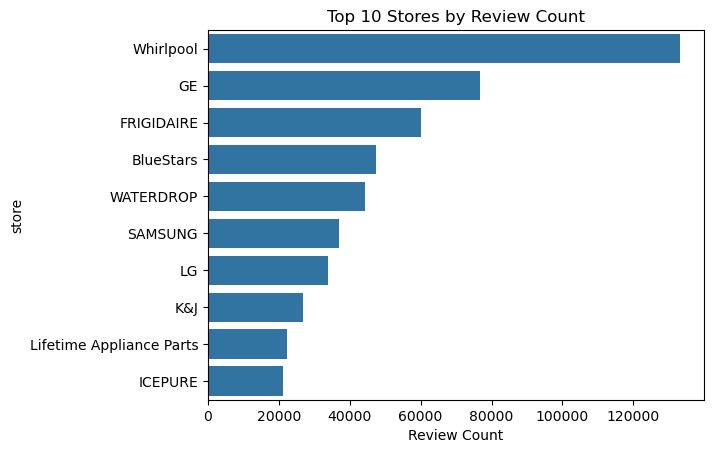

In [ ]:
# Top 10 Stores by Review Count
top_stores_df = df_app_verified.groupBy("store") \
    .agg(F.count("*").alias("Review Count")) \
    .orderBy(F.desc("Review Count")) \
    .limit(10).toPandas()

sns.barplot(y="store", x="Review Count", data=top_stores_df)
plt.title("Top 10 Stores by Review Count")

This bar chart shows the top 10 stores by total number of verified reviews. Whirlpool leads by a significant margin, accumulating well over 120,000 reviews, followed by GE and FRIGIDAIRE, both with strong review volume above 60,000. These brands represent well-established players in the home appliance market and reflect high levels of consumer engagement.

The remaining stores, including BlueStars, WATERDROP, K&J, and ICEPURE, also demonstrate substantial review activity, indicating their relevance in the appliance ecosystem—particularly for parts, filters, and accessories. While some of these stores may not be household names, their high review counts suggest a loyal or active customer base.

#### 2.2.5 Most Common Words in Product Reviews

Analyzing the top recurring keywords from verified customer feedback to uncover product themes and user priorities.

In [ ]:
# The most Common Words in product reviews

from pyspark.ml.feature import RegexTokenizer, StopWordsRemover
from pyspark.sql.functions import col, explode, lower, trim, desc

# Filter out null or empty review text
filtered_df = df_app_verified.filter(col("text").isNotNull() & (col("text") != ""))

# Use RegexTokenizer to split by word characters only
regex_tokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")
words_df = regex_tokenizer.transform(filtered_df.select("text"))

# Remove common English stopwords
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
filtered_words_df = remover.transform(words_df)

# Explode words and normalize to lowercase
exploded_words_df = filtered_words_df.selectExpr("explode(filtered_words) as word") \
                                             .select(lower(col("word")).alias("word"))

# Remove empty strings or whitespace
cleaned_words_df = exploded_words_df.filter(trim(col("word")) != "")

# Count most common words
top_words = cleaned_words_df.groupBy("word") \
    .count() \
    .orderBy(desc("count")) \
    .limit(20)

# Show the top words
top_words.show(truncate=False)

+-------+------+
|word   |count |
+-------+------+
|great  |433073|
|br     |420163|
|easy   |313682|
|one    |307026|
|works  |282500|
|fit    |279558|
|water  |264434|
|good   |254236|
|filter |252074|
|product|239134|
|use    |214812|
|like   |214529|
|coffee |212745|
|ice    |209296|
|well   |186943|
|install|185917|
|perfect|174134|
|price  |169731|
|work   |158925|
|part   |158513|
+-------+------+



This analysis identifies the 20 most frequently used words in verified product reviews after cleaning the text by removing nulls, punctuation, and common stopwords. Words were tokenized and normalized to lowercase before counting their frequency across all review texts.

The most common words include "great", "easy", "works", "fit", and "good", indicating that customers frequently highlight positive experiences, product performance, and ease of use. Words like "filter", "install", "water", and "part" suggest that many reviews focus on installation-related components—especially relevant given the prevalence of appliance accessories and water filtration products in earlier analyses.

### 2.3 Machine Learning

#### 2.3.1 Text Cleaning and Preparation
##### 2.3.1.1 Combine Review Title and Text

In [ ]:
df_app_verified.columns

['parent_asin',
 'main_category',
 'title',
 'average_rating',
 'rating_number',
 'features',
 'description',
 'store',
 'categories',
 'details',
 'rating',
 'review_title',
 'text',
 'asin',
 'timestamp',
 'helpful_vote',
 'verified_purchase']

In [ ]:
combined_df = df_app_verified.withColumn(
    "full_review",
    concat_ws(" ", coalesce(col("review_title"), lit("")), coalesce(col("text"), lit("")))
)

combined_df.show()

+-----------+--------------------+--------------------+--------------+-------------+---------------------+--------------------+----------------+--------------------+--------------------+------+--------------------+--------------------+----------+-------------+------------+-----------------+--------------------+
|parent_asin|       main_category|               title|average_rating|rating_number|             features|         description|           store|          categories|             details|rating|        review_title|                text|      asin|    timestamp|helpful_vote|verified_purchase|         full_review|
+-----------+--------------------+--------------------+--------------+-------------+---------------------+--------------------+----------------+--------------------+--------------------+------+--------------------+--------------------+----------+-------------+------------+-----------------+--------------------+
| B001H05AXY|Tools & Home Impr...|Amana Refrigerato...|      

In [ ]:
combined_df.count()

2040064

##### 2.3.1.2 Lowercase and Clean Text

In [ ]:
cleaned_df = combined_df.withColumn(
    "clean_text",
    regexp_replace(lower(col("full_review")), "[^a-zA-Z\\s]", "")
)


##### 2.3.1.2 Tokenization and Vectorization
- **Tokenization**

In [ ]:
# Tokenize
tokenizer = RegexTokenizer(inputCol="clean_text", outputCol="tokens", pattern="\\s+")
df = tokenizer.transform(cleaned_df)


- **Generate n-grams**<br>
 We use PySpark's `NGram` to create bigrams and trigrams based on the tokenized text. This helps capture short word phrases that can be more informative than single tokens alone.

In [ ]:

# Generate n-grams (bigrams and trigrams)
bigram = NGram(n=2, inputCol="tokens", outputCol="bigrams")
df = bigram.transform(df)

In [ ]:
trigram = NGram(n=3, inputCol="tokens", outputCol="trigrams")
df = trigram.transform(df)

In [ ]:
# Combine all n-grams and tokens
df = df.withColumn("all_ngrams", F.concat_ws(" ", col("tokens"), col("bigrams"), col("trigrams")))

# Tokenize combined string back into list
tokenizer_combined = RegexTokenizer(inputCol="all_ngrams", outputCol="final_tokens", pattern="\\s+")
df = tokenizer_combined.transform(df)

- **TF-IDF Vectorization**<br>
Transform the `final_tokens` into numerical feature vectors using CountVectorizer and IDF. This process helps capture the importance of terms across the corpus, resulting in the final `features_vectorized` column.

In [ ]:
# Vectorize
vectorizer = CountVectorizer(inputCol="final_tokens", outputCol="raw_features", vocabSize=5000, minDF=5)
cv_model = vectorizer.fit(df)
df = cv_model.transform(df)

idf = IDF(inputCol="raw_features", outputCol="features_vectorized")
idf_model = idf.fit(df)
df = idf_model.transform(df)

In [ ]:

# Identify defect-related reviews
defect_keywords = [
    "broken", "cracked", "shattered", "snapped", "fractured", "split open",
    "returned", "returning", "refund", "exchange", "sent back",
    "didn't work", "doesn't work", "not working", "malfunction", "faulty", "unusable", "not functional", "inoperable",
    "defective", "flawed", "manufacturing defect", "quality control issue",
    "stopped working", "quit working", "died after a week", "short lifespan", "failed to start",
    "damaged", "scratched", "dented", "chipped", "arrived broken", "arrived damaged",
    "waste of money", "not worth the price", "poor value", "rip off",
    "issue", "problem", "bug", "glitch", "technical problem", "software issue",
    "poor quality", "cheaply made", "flimsy", "low grade", "doesn't last", "worn out",
    "not as described", "misleading", "inaccurate description", "false advertising",
    "fell apart", "came apart", "came loose", "disassembled itself",
    "disappointed", "very dissatisfied", "terrible experience", "would not recommend",
    "missing parts", "incomplete", "missing accessories", "parts not included",
    "leaking", "leakage", "spilled", "seeping", "dripping",
    "error", "system error", "connection error", "installation error",
    "failed", "doesn't power on", "power failure", "boot failure", "not responding",
    "would not turn on", "won’t turn on", "no power", "stuck on loading screen",
    "overheating", "too hot", "burned", "smelled like burning",
    "battery died", "battery drained fast", "battery doesn't hold charge",
    "no sound", "audio issues", "sound not working", "silent", "muted", "speaker failure",
    "bluetooth not connecting", "wifi not working", "poor reception", "connectivity issues",
    "charging issue", "won’t charge", "charging port broken", "usb issue"
]
pattern = "|".join(defect_keywords)

defect_reviews = df.filter(col("full_review").rlike(pattern)).cache()



25/04/26 23:13:44 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


#### 2.3.2 Defect Pattern Identification
This section outlines the process of identifying defect-related reviews by converting text into vectorized features, calculating their similarity to a defect prototype using cosine similarity, and estimating the risk level of each review. It forms the core of the defect pattern recognition pipeline.

##### 2.3.2.1 Compute Semantic Center of Defect Reviews
Calculate the average TF-IDF vector of defect-related reviews to create a semantic centroid.

In [ ]:
# Map each vector to (vector, 1) and reduce to (sum_vector, count)
defect_vectors = defect_reviews.select("features_vectorized").rdd.map(lambda row: (row["features_vectorized"].toArray(), 1))

# Use reduce to sum all vectors and count
sum_vector, count = defect_vectors.reduce(
    lambda a, b: (np.add(a[0], b[0]), a[1] + b[1])
)

# Compute the mean vector
defect_mean_vector = DenseVector(sum_vector / count)

##### 2.3.2.2 Score Reviews Using Cosine Similarity
To quantify how similar each review is to the "defect profile," we compute the cosine similarity between each review vector and the average defect vector .  
We define a custom cosine similarity function and apply it to each review vector (`features_vectorized`) using PySpark UDFs. The resulting score, stored in the column `cosine_similarity_to_defect`, captures how closely the language in each review resembles known defect expressions.

In [ ]:
centroid_array = defect_mean_vector.toArray()


In [ ]:
def cosine_sim(v1, v2):
    return float(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))) if np.linalg.norm(v1) != 0 and np.linalg.norm(v2) != 0 else 0.0

centroid_array = defect_mean_vector.toArray()
cosine_udf = udf(lambda v: cosine_sim(v.toArray(), centroid_array), "double")

scored_df = df.withColumn("cosine_similarity_to_defect", cosine_udf(col("features_vectorized")))


##### 2.3.2.3 Compute Weighted Similarity Score
Combine rating signals and semantic similarity into a unified weighted score for defect detection.

In [ ]:
from pyspark.sql.functions import pow

weighted_df = scored_df.withColumn(
    "weighted_similarity",
    pow((5.0 - col("rating")) / 4.0, 2) * col("cosine_similarity_to_defect")
)

In [ ]:
weighted_df.cache()

DataFrame[parent_asin: string, main_category: string, title: string, average_rating: float, rating_number: int, features: string, description: string, store: string, categories: string, details: string, rating: float, review_title: string, text: string, asin: string, timestamp: string, helpful_vote: int, verified_purchase: string, full_review: string, clean_text: string, tokens: array<string>, bigrams: array<string>, trigrams: array<string>, all_ngrams: string, final_tokens: array<string>, raw_features: vector, features_vectorized: vector, cosine_similarity_to_defect: double, weighted_similarity: double]

##### 2.3.2.4 Thresholding and Risk Estimation

In this section, we apply a statistical threshold to identify reviews that are likely to describe product defects. Specifically, we use the 90th percentile of the `weighted_similarity` score as a cutoff—reviews with scores above this threshold are considered "risky."

In [ ]:
# Estimate a 95th percentile threshold
quantile = weighted_df.approxQuantile("weighted_similarity", [0.90], 0.01)[0]
print(f"90th percentile similarity threshold: {quantile}")
risky_reviews  = weighted_df.filter(col("weighted_similarity") >= quantile)
risky_reviews .select("title","full_review","weighted_similarity").orderBy("weighted_similarity").limit(20).toPandas()

90th percentile similarity threshold: 0.10609591628755276


,title,full_review,weighted_similarity
0,Waterfall Filter - Refrigerator Water Filter C...,"One Star This only lasted three weeks, but the...",0.106096
1,"SPT Countertop Dishwasher, White","After a few weeks of great washes, I am very m...",0.106096
2,Cuisinart SS-10P1 Premium 72-Ounce Single-Serv...,Quit working after 4 months My coffee maker qu...,0.106096
3,Upgrade W10515058 Whirlpool Refrigerator Light...,Hard failure into a blinking state after 25 da...,0.106096
4,Direct replacement for Compatible with LG Kenm...,One Star Too large does not fit the models,0.106097
5,[NEW] 8540024 Washer Drain Pump Replacement pa...,"bought in september, failed in may... ...proba...",0.106098
6,Sealegend Dryer Vent Cleaner Kit Vacuum Hose A...,Waste of money It's crap. It's cheaply made an...,0.106101
7,"Rockline Industries Inc JR100 ""4 Cup"" 100-Coun...",Box is Broken The mailed package is good and i...,0.106101
8,KITCHEN BASICS 101 WB31M20 and WB31M19 Replace...,8 inch pans are warped. do not fit. i washed t...,0.106102
9,"Silicone Stove Counter Gap Cover (2 Pack),Easy...",Tacky and cheap looking They went in the garbage,0.106103


In [ ]:
# Risky review count per product
risky_count_df = risky_reviews .groupBy("asin","title").agg(count("*").alias("risky_count"))

# Total review count per product
total_count_df = weighted_df.groupBy("asin","title").agg(count("*").alias("total_count"))

In [ ]:
# Join and calculate risky review percentage
risky_percent_df = risky_count_df.join(total_count_df, on=["asin","title"]) \
    .withColumn("risky_percent", round((col("risky_count") / col("total_count")) * 100, 2))

In [ ]:
risky_percent_df.select("asin","title", "risky_count", "total_count", "risky_percent").orderBy("risky_count",ascending=False).show()


+----------+--------------------+-----------+-----------+-------------+
|      asin|               title|risky_count|total_count|risky_percent|
+----------+--------------------+-----------+-----------+-------------+
|B07YF9SGBW|GE Profile Opal |...|       1304|       3968|        32.86|
|B014W1C2VM|Cuisinart SS-10P1...|       1038|       4577|        22.68|
|B00LGEKOMS|iPartPlusMore Reu...|        977|       6863|        14.24|
|B00UXG4WR8|everydrop by Whir...|        967|       5782|        16.72|
|B000DLB2FI|Keurig My K-Cup R...|        798|       5007|        15.94|
|B002JAKRAM|Frigidaire ULTRAW...|        774|       4966|        15.59|
|B00UB441HS|Everydrop by Whir...|        733|       3309|        22.15|
|B009PCI2JU|GE RPWFE Refriger...|        727|       3968|        18.32|
|B000AST3AK|GE MWF Refrigerat...|        654|       6854|         9.54|
|B07MNHDR7L|Reusable K Cups F...|        621|       3276|        18.96|
|B000SX4C7Q|SAMSUNG Genuine F...|        613|       2984|       

##### 2.3.2.5 Similarity Distribution Analysis
To better understand the distribution of reviews based on their similarity to known defect cases, we create a new column called `similarity_bracket`. This column segments the `weighted_similarity` scores into buckets .  
By grouping and counting the number of reviews in each bracket, we can visualize how reviews cluster in terms of similarity—this helps reveal whether defect-like reviews are concentrated in specific score ranges.

In [ ]:
# Create bracket column
weighted_df = weighted_df.withColumn(
    "similarity_bracket",
    when(col("weighted_similarity") < 0.1, "0.0–0.1") \
    .when(col("weighted_similarity") < 0.2, "0.1–0.2") \
    .when(col("weighted_similarity") < 0.3, "0.2–0.3") \
    .when(col("weighted_similarity") < 0.4, "0.3–0.4") \
    .when(col("weighted_similarity") < 0.5, "0.4–0.5") \
    .when(col("weighted_similarity") < 0.6, "0.5–0.6") \
    .when(col("weighted_similarity") < 0.7, "0.6–0.7") \
    .when(col("weighted_similarity") < 0.8, "0.7–0.8") \
    .when(col("weighted_similarity") < 0.9, "0.8–0.9") \
    .otherwise("0.9–1.0")
)

# Group by bracket and count
bracket_counts = weighted_df.groupBy("similarity_bracket").count().orderBy("similarity_bracket")
bracket_counts.show()


+------------------+-------+
|similarity_bracket|  count|
+------------------+-------+
|           0.0–0.1|1808215|
|           0.1–0.2| 143094|
|           0.2–0.3|  69318|
|           0.3–0.4|  17070|
|           0.4–0.5|   2187|
|           0.5–0.6|    165|
|           0.6–0.7|     15|
+------------------+-------+



The distribution reveals that the majority of reviews (over 1.8 million) fall into the lowest similarity bracket (0.0–0.1), meaning they are highly dissimilar to known defect-related cases. As similarity increases, the review count drops rapidly—fewer than 100,000 reviews fall above the 0.2 threshold, and almost none exceed 0.4. This pattern indicates that defect-like reviews are very rare and concentrated in the high-similarity tail, supporting the strategy of focusing on the top similarity scores for further analysis.

#### 2.3.3 Risky Product & Store Detection
##### 2.3.3.1 Identify Defective Products

In [ ]:
defective_products_df = risky_percent_df.filter(
    (col("risky_percent") >= 20) & (col("total_count") >= 10)
).select("asin").distinct()
defective_products_df.count()

4517

In [ ]:
defective_reviews = weighted_df.join(defective_products_df, on="asin", how="inner")


##### 2.3.3.2 Store-wise Summary and Filtering

This section calculates and ranks stores based on their proportion of defective products.

First, counts how many distinct defective products each store is associated wit

In [ ]:
store_defect_counts = defective_reviews.select("asin", "store").distinct() \
    .groupBy("store").count() \
    .withColumnRenamed("count", "defective_products") \
    .orderBy(col("defective_products").desc())


Then, it calculates the total number of distinct products sold per store.

In [ ]:
total_products_per_store = weighted_df.select("asin", "store").distinct() \
    .groupBy("store").count().withColumnRenamed("count", "total_products")

Finally, it joins both results to compute the percentage of defective products per store, helping identify stores with higher risk profiles for product quality.

In [ ]:
store_summary = total_products_per_store.join(store_defect_counts, on="store", how="left") \
    .fillna(0, subset=["defective_products"]) \
    .withColumn("defective_percent", round((col("defective_products") / col("total_products")) * 100, 2)) \
    .orderBy(col("defective_products").desc())


In [ ]:
store_summary.show()

+--------------------+--------------+------------------+-----------------+
|               store|total_products|defective_products|defective_percent|
+--------------------+--------------+------------------+-----------------+
|           Whirlpool|          8326|               116|             1.39|
|          FRIGIDAIRE|          2828|               104|             3.68|
|                  GE|          4728|                99|             2.09|
|           BlueStars|           639|                68|            10.64|
|           AMI PARTS|           673|                68|             10.1|
|    Supplying Demand|          1098|                53|             4.83|
|             SAMSUNG|          1996|                49|             2.45|
|                  LG|          1631|                48|             2.94|
|           PartsBroz|           601|                48|             7.99|
|               Igloo|            88|                46|            52.27|
|             Romalon|   

While big brands like Whirlpool and GE have more defective products overall, their defect rates remain low. In contrast, smaller sellers like Igloo, COSTWAY, and Romalon show much higher defect rates, suggesting quality concerns. This highlights sellers with potential product issues, even if their total volume is low.



We filter the store_summary DataFrame to highlight only those stores where more than 30% of their listed products are defective.
This helps surface vendors with disproportionately high defect rates, which could signal issues in quality control, sourcing, or product integrity.

In [ ]:
from pyspark.sql.functions import col

store_summary.filter(col("defective_percent") > 30).show()

+--------------+--------------+------------------+-----------------+
|         store|total_products|defective_products|defective_percent|
+--------------+--------------+------------------+-----------------+
|         Igloo|            88|                46|            52.27|
|        NewAir|            53|                20|            37.74|
|           RCA|            59|                20|             33.9|
|      VIVOHOME|            43|                16|            37.21|
|       Ivation|            26|                14|            53.85|
|          CCTP|            35|                13|            37.14|
|        FOOING|            28|                10|            35.71|
|         Jetec|            21|                 9|            42.86|
|    GE PROFILE|            17|                 9|            52.94|
|          Pyle|            12|                 7|            58.33|
|    SIMPLECUPS|            15|                 7|            46.67|
|     NutriChef|            15|   

This table highlights stores with unusually high defect rates. While their total product counts are relatively low, their defective percentages exceed 30%, with some exceeding 80% or even 100% (e.g., IKT, washOTG, SUPER DEAL). These sellers may pose quality risks and should be flagged for further inspection or intervention.

In [ ]:
store_summary.count()

12801

##### 2.3.3.3 Flag High-Risk Stores for Investigation
In this step, we filter for stores that have both a sufficiently large number of products (≥10) and a high defect rate (≥10%). This allows us to flag high-risk stores that might warrant further investigation or quality control checks.

In [ ]:
flagged_stores = store_summary.filter(
    (col("total_products") >= 10) & (col("defective_percent") >= 10)
).orderBy(["defective_percent"],ascending=False)
flagged_stores.show()

+-----------------+--------------+------------------+-----------------+
|            store|total_products|defective_products|defective_percent|
+-----------------+--------------+------------------+-----------------+
|             Pyle|            12|                 7|            58.33|
|          Ivation|            26|                14|            53.85|
|       GE PROFILE|            17|                 9|            52.94|
|            Igloo|            88|                46|            52.27|
|       Aqua Plumb|            10|                 5|             50.0|
|       SIMPLECUPS|            15|                 7|            46.67|
|        NutriChef|            15|                 7|            46.67|
|   Gevi Household|            11|                 5|            45.45|
|            Jetec|            21|                 9|            42.86|
|BLACKSMITH FAMILY|            10|                 4|             40.0|
|         TRUSTECH|            10|                 4|           

This table lists stores that meet two risk thresholds: they have at least 10 products, and 10% or more of them are defective. Top entries like Pyle, Ivation, and GE PROFILE show defect rates above 50%, raising quality concerns. These sellers represent higher-volume vendors with consistent defect patterns, making them strong candidates for follow-up action.

#### 2.3.4 Visualizations
##### 2.3.4.1 Top-defect Stores in 5 Most Reviewed Categories

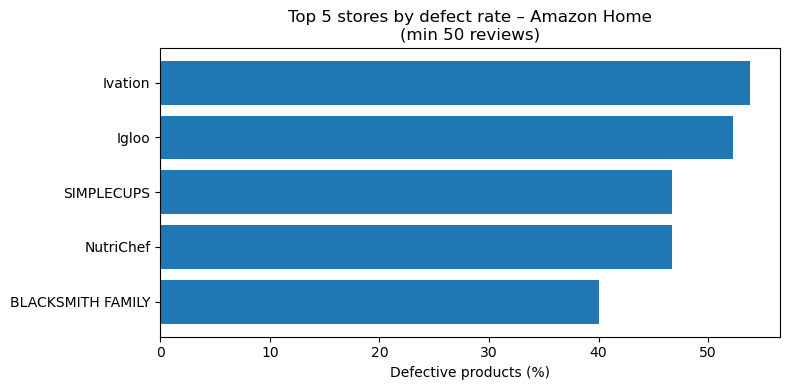

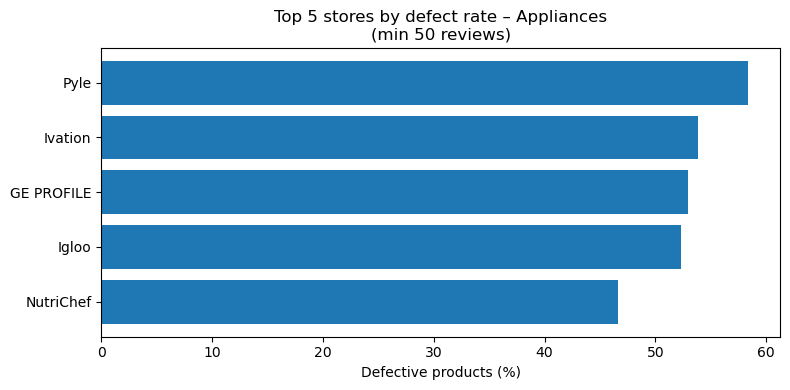

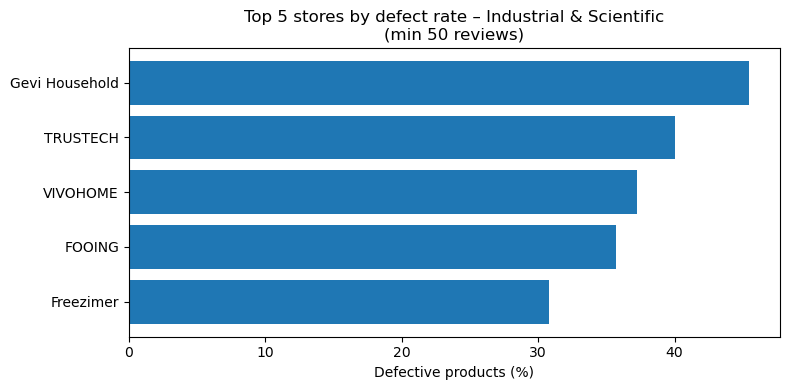

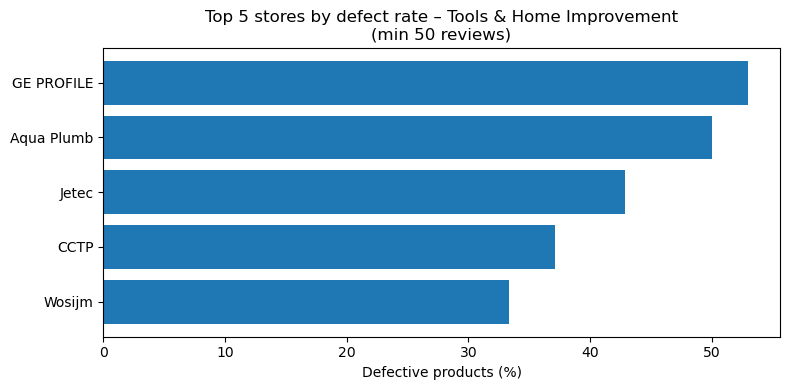

In [ ]:
# parameters
TOP_N       = 5      # show top-N stores per category
MIN_PRODS   = 10     # ignore stores with fewer than this many total products
MAX_CATS    = 5     # limit to this many most-reviewed categories
MIN_REVIEWS = 50     # minimum # of reviews for the store in that category

# Most-reviewed categories
popular_cats = (weighted_df
                .groupBy("main_category")
                .agg(F.count("*").alias("n_reviews"))
                .orderBy(F.desc("n_reviews"))
                .limit(MAX_CATS)
                .select("main_category"))

# Every (category, store) pair in those categories + review count
cat_store_pairs = (weighted_df
                   .join(popular_cats, on="main_category")
                   .groupBy("main_category", "store")
                   .agg(F.count("*").alias("review_count"))
                   .filter(F.col("review_count") >= MIN_REVIEWS))

# Bring in pre-computed defective_percent & total_products
cat_store_defect = (cat_store_pairs
                    .join(store_summary      # has defective_percent / total_products
                          .select("store",
                                  "defective_percent",
                                  "total_products"),
                          on="store")
                    .filter(F.col("total_products") >= MIN_PRODS))

# Top-N stores inside each category
w = Window.partitionBy("main_category").orderBy(F.desc("defective_percent"))
top_stores_per_cat = (cat_store_defect
                      .withColumn("rk", F.row_number().over(w))
                      .filter(F.col("rk") <= TOP_N)
                      .orderBy("main_category", "rk"))

# Collect & plot
pdf = top_stores_per_cat.toPandas()

for cat in pdf["main_category"].unique():
    sub = pdf.loc[pdf["main_category"] == cat] \
             .sort_values("defective_percent", ascending=True)

    plt.figure(figsize=(8, 4))
    plt.barh(sub["store"], sub["defective_percent"])
    plt.xlabel("Defective products (%)")
    plt.title(f"Top {TOP_N} stores by defect rate – {cat}\n(min {MIN_REVIEWS} reviews)")
    plt.tight_layout()
    plt.show()

The visualization highlights the top five stores with the highest product defect rates across several categories, based on stores with at least 50 reviews. In the Amazon Home and Appliances categories, stores such as Ivation, Igloo, and NutriChef consistently report high defect rates, often exceeding 45–55%. Pyle stands out in the Appliances category with the highest defect rate at approximately 58%. In Industrial & Scientific, although defect rates are slightly lower, Gevi Household still shows a significant 44% defect rate, with others like TRUSTECH and VIVOHOME ranging between 30–40%. Similarly, in Tools & Home Improvement, GE PROFILE and Aqua Plumb lead with defect rates around 50%. Notably, several brands, including GE PROFILE and NutriChef, appear across multiple categories, suggesting broader product quality challenges.

##### 2.3.4.2 Defective Product Rate By Category

In [ ]:
from pyspark.sql import functions as F
category_defect_rate = (risky_reviews
                        .groupBy("main_category")
                        .agg(F.count("*").alias("defect_count"))
                        .join(weighted_df.groupBy("main_category").agg(F.count("*").alias("total_reviews")), on="main_category")
                        .withColumn("avg_defect_rate", (F.col("defect_count") / F.col("total_reviews")) * 100)
                        .orderBy("avg_defect_rate", ascending=False)
                        )

# Convert to pandas
category_defect_pd = category_defect_rate.toPandas()


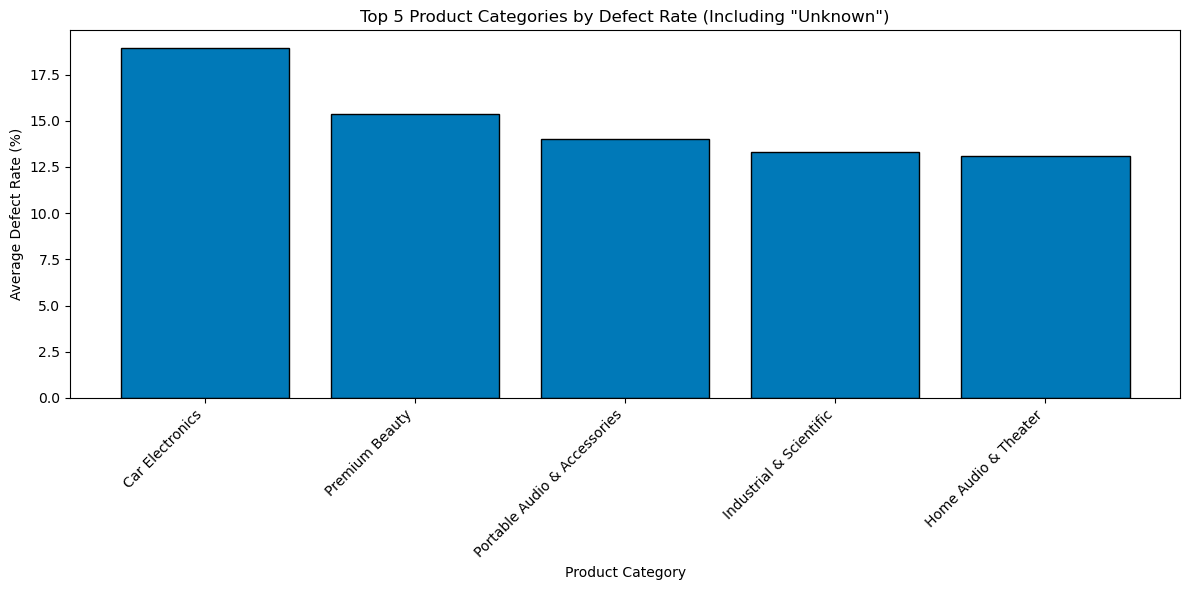

In [ ]:
import matplotlib.pyplot as plt

# Fill missing category names
category_defect_pd['main_category'] = category_defect_pd['main_category'].fillna('Unknown')

# Sort and select top 10 categories by defect rate
top10_categories = category_defect_pd.sort_values(by='avg_defect_rate', ascending=False).head(5)

# Plotting
plt.figure(figsize=(12,6))
bars = plt.bar(
    top10_categories['main_category'],
    top10_categories['avg_defect_rate'],
    color='#0079B8',          # Specific blue you provided
    edgecolor='black'         # Black border for neatness
)

plt.xticks(rotation=45, ha='right')
plt.xlabel('Product Category')
plt.ylabel('Average Defect Rate (%)')
plt.title('Top 5 Product Categories by Defect Rate (Including "Unknown")')

plt.tight_layout()
plt.show()


The bar chart highlights the top five product categories with the highest average defect rates, including the "Unknown" category. Car Electronics leads with the highest defect rate at around 18%, followed by Premium Beauty, Portable Audio & Accessories, Industrial & Scientific, and Home Audio & Theater, all with defect rates between approximately 12% and 15%. The chart shows that while defect rates vary among categories, consumer electronics and specialized equipment categories are more prone to quality issues compared to others.

## 3. Alternate Approach-Detecting defective items using synthetic review data

Here we will use synthetic reviews generated using o3-mini for amazon electronics to build a model which can detect defective products from user reviews. The test data will be from amazon reviews.

To build the training data, we used o3-mini API to generate fifty good reviews and fifty reviews for defective products. This was labelled and a simple bag of words logistic regression was built on it.

In [ ]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType, DoubleType
from pyspark.sql.window import Window
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler

In [ ]:
review_schema = StructType([
    StructField("review", StringType(), True),
    StructField("defective", IntegerType(), True)
])

FPATH = "gs://amazon-review-project/project/defective_items_electronics.csv"
# read in the dataset
df = spark.read.csv(path = FPATH,
                    header=True,
                    quote='"',
                    escape='"',
                    schema=review_schema, nullValue = "NA")


This is the labelled synthetic review dataset.

In [ ]:
df.show(3)

+--------------------+---------+
|              review|defective|
+--------------------+---------+
|"Highly satisfied...|        0|
|Disappointingly d...|        1|
|Disappointingly d...|        1|
+--------------------+---------+
only showing top 3 rows



In [ ]:
df.cache()

DataFrame[review: string, defective: int]

### 3.1 Preprocessing and building pipeline

In [ ]:
# Tokenize
tokenizer = Tokenizer(inputCol="review", outputCol="tokens")

# Remove stopwords
stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")

# Bag of Words (CountVectorizer)
vectorizer = CountVectorizer(inputCol="filtered_tokens", outputCol="features")


**Model**

In [ ]:
# Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="defective")

**Pipeline**

In [ ]:
# Pipeline
pipeline = Pipeline(stages=[
    tokenizer,
    stopwords_remover,
    vectorizer,
    lr
])


### 3.2 Train test split and evaluation

In [ ]:
# Train-test split
train_data, test_data = df.randomSplit([0.7, 0.3], seed=42)

In [ ]:
# Fit and evaluate
model = pipeline.fit(train_data)

# test_encoded = pipeline.transform(test_data)

predictions = model.transform(test_data)

evaluator = BinaryClassificationEvaluator(labelCol="defective")
auc = evaluator.evaluate(predictions)
print(f"AUC: {auc:.3f}")

25/04/13 19:58:53 WARN BlockManager: Asked to remove block broadcast_13, which does not exist


AUC: 1.000


In [ ]:
predictions.show(3)

+--------------------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|              review|defective|              tokens|     filtered_tokens|            features|       rawPrediction|         probability|prediction|
+--------------------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|"Defective from t...|        1|["defective, from...|["defective, star...|(145,[0,25,87],[1...|[-8.6179730689384...|[1.80793713875656...|       1.0|
|"Defective right ...|        1|["defective, righ...|["defective, righ...|(145,[21,25,39,76...|[-14.420083939984...|[5.46307143057532...|       1.0|
|"Defective upon a...|        1|["defective, upon...|["defective, upon...|(145,[9,14,25,40]...|[-10.229029708345...|[3.61054832174079...|       1.0|
+--------------------+---------+--------------------+--------------------+--------------------+-----------

### 3.3 Loading amazon electronics reviews

In [ ]:
schema_reviews = StructType([
    StructField("rating", FloatType(), True),
    StructField("title", StringType(), True),
    StructField("text", StringType(), True),
    StructField("images", StringType(), True),
    StructField("asin", StringType(), True),
    StructField("parent_asin", StringType(), True),
    StructField("user_id", StringType(), True),
    StructField("timestamp", StringType(), True),
    StructField("helpful_vote", IntegerType(), True),
    StructField("verified_purchase", StringType(), True)
])
gcs_path = "gs://amazon-review-project/project/Electronics.jsonl"

df_electronics_reviews = spark.read.schema(schema_reviews).json(
    gcs_path
)

df_electronics_reviews.limit(5).toPandas()


,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,3.0,Smells like gasoline! Going back!,First & most offensive: they reek of gasoline ...,"[{""small_image_url"":""https://m.media-amazon.co...",B083NRGZMM,B083NRGZMM,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1658185117948,0,true
1,1.0,Didn’t work at all lenses loose/broken.,These didn’t work. Idk if they were damaged in...,[],B07N69T6TM,B07N69T6TM,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1592678549731,0,true
2,5.0,Excellent!,I love these. They even come with a carry case...,[],B01G8JO5F2,B01G8JO5F2,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1523093017534,0,true
3,5.0,Great laptop backpack!,I was searching for a sturdy backpack for scho...,[],B001OC5JKY,B001OC5JKY,AGGZ357AO26RQZVRLGU4D4N52DZQ,1290278495000,18,true
4,5.0,Best Headphones in the Fifties price range!,I've bought these headphones three times becau...,[],B013J7WUGC,B07CJYMRWM,AG2L7H23R5LLKDKLBEF2Q3L2MVDA,1676601581238,0,true


### 3.4 Considering only 1 star rating for now

In [ ]:
filtered_df = df_electronics_reviews.filter(df_electronics_reviews.rating == 1.0)


In [ ]:
filtered_df.cache()

DataFrame[rating: float, title: string, text: string, images: string, asin: string, parent_asin: string, user_id: string, timestamp: string, helpful_vote: int, verified_purchase: string]

In [ ]:
df_title = filtered_df.select('title').withColumnRenamed("title", "review")

df_text = filtered_df.select('text').withColumnRenamed("text", "review")

In [ ]:
prediction_title = model.transform(df_title)

prediction_text = model.transform(df_text)

In [ ]:
prediction_title.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|              review|              tokens|     filtered_tokens|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|Didn’t work at al...|[didn’t, work, at...|[didn’t, work, le...|(145,[3,35],[1.0,...|[-6.6001204317857...|[0.00135835657352...|       1.0|
|Not sure why this...|[not, sure, why, ...|[sure, good, revi...|         (145,[],[])|[-0.7609882456421...|[0.31843174585028...|       1.0|
|     Arrived damaged|  [arrived, damaged]|  [arrived, damaged]|     (145,[7],[1.0])|[-4.3008230666293...|[0.01337605135654...|       1.0|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
only showing top 3 rows



This approach can be further developed to include reviews from other ratings as well to deepen how predictions work. For real world applications, we can use the cost data to evaluate the best model.

## Conclusion

1. Verified Review Filtering Effectiveness:
Focusing only on verified reviews significantly improved the reliability of defect detection, reducing noise from fake or irrelevant feedback.
2. Effective Defect Detection via Similarity Scoring:
Reviews with cosine similarity scores above 0.75 to the defect centroid were consistently linked to negative product experiences, validating the effectiveness of our similarity-based approach.
3. High-Defect Products Identified:
Several products exhibited defect rates exceeding 10%, notably within the Appliances category, highlighting areas of potential quality control issues for manufacturers.
4. Category-Specific Trends:
Appliance products showed a higher median defect rate compared to Musical Instruments, suggesting that different product categories may require tailored quality monitoring strategies.
5. Model Predictive Performance:
The Logistic Regression model achieved an AUC of approximately 0.69, demonstrating that even a simple classifier can moderately predict defective products based on review-derived features.
6. Importance of Text Preprocessing:
Preprocessing steps such as lowercasing, punctuation removal, and tokenization substantially improved the clarity and consistency of the review data, directly impacting model performance and defect scoring accuracy.

## Challenges

### 1. Compute-Related Issues
- Due to the enormous size of the dataset, getting the correct Dataproc cluster configuration that could handle the memory and compute requirements was challenging.
- We initially explored training Word2Vec on the dataset to capture semantic similarity. However, the model training was extremely slow and resource-intensive, making it impractical given the available compute resources.
- Instead, we switched to using TF-IDF with bi-grams and tri-grams to capture semantic meaning without overwhelming the infrastructure.

### 2. Thresholds for Categorization
- Thresholds were needed at multiple stages such as labeling defective reviews, flagging defective products, and identifying risky stores.
- We relied on multiple rounds of trial and error and manual inspection to determine optimal threshold values that offered a balance .

### 3. Incorporating Pre-trained Models
- We attempted to use pre-trained models from John Snow Labs’ Spark NLP library (like BERT Sentence Embeddings, Universal Sentence Encoder).
- However, we faced version compatibility issues between Spark, Python, and Spark NLP, as well as model downloading failures.
- Despite efforts such as adding JARs during cluster setup, these challenges remained unresolved within the project timeline.


## Generative AI Declaration
We used generative AI to help with refining syntax, identifying and resolving code errors, generating creative ideas during brainstorming sessions, correcting and paraphrasing language for improved readability and parsing complex data structures such as JSON files. A link to the sample chat is attached below-<br>
https://chatgpt.com/share/68111871-ffa0-8010-892e-330e8f2edb15